## Function

In [1]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
#     plt.figure()
#     generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
#     plt.show()

C:\Anaconda\envs\jcopml\lib\site-packages\ipykernel\parentpoller.py:113: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

In [3]:
def show_values(axs, orient="v", space=.01, fmt='{:.4f}', fsize=18):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = fmt.format(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize=fsize) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = fmt.format(p.get_width())
                ax.text(_x, _y, value, ha="left", fontsize=fsize)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## Library

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import pyswarms as ps
import matplotlib.pyplot as plt
import xlsxwriter

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from collections import Counter

from sklearn.metrics import confusion_matrix
import itertools

from ipynb.fs.full.DistanceWeightedKNN import DistanceWeightedKNN

In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Anaconda\envs\jcopml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

## Preprocessing

In [5]:
df= pd.read_csv("DATASET/LungCancer.csv")
df.head(10)

Class  1000_at  1001_at  1002_f_at  1003_s_at  1004_at  1005_at  \
0  Mesothelioma    199.1     38.7       -1.0      -55.9      4.5   1042.5   
1  Mesothelioma    188.5     82.0      -10.1       30.5     -6.6    877.1   
2  Mesothelioma    284.1     35.6      -19.6     -111.2    -25.0    993.4   
3  Mesothelioma    204.5     20.4        9.4      -99.5    -10.1    273.9   
4  Mesothelioma    213.1     98.3       31.4       46.1     75.0   1568.6   
5  Mesothelioma    487.3     27.2       11.5      212.0   -121.2    709.2   
6  Mesothelioma    187.0     39.3       -3.8     -117.0      6.0   1921.7   
7  Mesothelioma    288.5     17.1       29.9     -114.1      2.3    345.6   
8  Mesothelioma    133.7     44.4       11.7      -12.5     -1.0    214.4   
9  Mesothelioma    320.1     59.0       19.1      -77.2    -11.6   4882.0   

   1006_at  1007_s_at  1008_f_at  ...  989_at  990_at  991_g_at  992_at  \
0    -12.0      783.2      320.9  ...    77.4     8.6      12.7    26.3   
1     71.0      309.9     2347.2  ...    47.4    14.5     -32.3    24.0   
2     11.3      594.1      485.4  ...    36.3    13.2      59.0     1.8   
3     22.8      713.3      250.0  ...    59.6    18.9      18.7    28.5   
4     17.8      769.2     4540.3  ...     5.7    14.7      68.9    25.5   
5    -84.3      461.0     7201.6  ...    40.1    44.2      15.1    -2.9   
6     -5.4      579.5      760.5  ...    69.9     8.6      80.1    11.7   
7    -18.2      554.4     1693.9  ...    28.8    33.5      62.7     8.7   
8     -2.3      365.6      644.7  ...    22.2    12.1      16.8    13.4   
9      4.1      420.1      993.9  ...    49.3    11.3      70.5    29.2   

   993_at  994_at  995_g_at  996_at  998_s_at  999_at  
0   176.9    22.2      41.8    36.1      21.8     3.2  
1    78.5    24.4      52.6    28.9      -6.6    40.6  
2    49.3     1.5      52.2   257.0      25.1   -79.6  
3   193.3     5.4      41.7     4.5      11.2   -43.3  
4    40.9   -38.2      27.7    62.2       8.3  -172.5  
5    95.5   -76.6      49.3    22.3     -14.0   -94.7  
6    53.2     8.4      16.4    40.6      25.1  -213.0  
7   131.5    43.7      -1.0   597.5      90.6  -238.9  
8   137.1    -0.1      21.6     7.4      28.1   -83.7  
9    92.7   -16.6      31.6     9.6      38.6   -84.7  

[10 rows x 12534 columns]

In [6]:
#jumlah class
df.Class.value_counts()

ADCA            150
Mesothelioma     31
Name: Class, dtype: int64

C:\Anaconda\envs\jcopml\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "legend" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app
2022-07-19 01:00:31,174 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-19 01:00:31,176 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-19 01:00:31,487 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-19 01:00:31,489 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-19 01:00:31,627 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-19 01:00:31,629 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-19 01:00:31,714 - matplotlib.text - WARNING - posx and posy should be finite values
2022-07-19 01:00:31,717 - matplotlib.text - WARNING - posx and posy should be

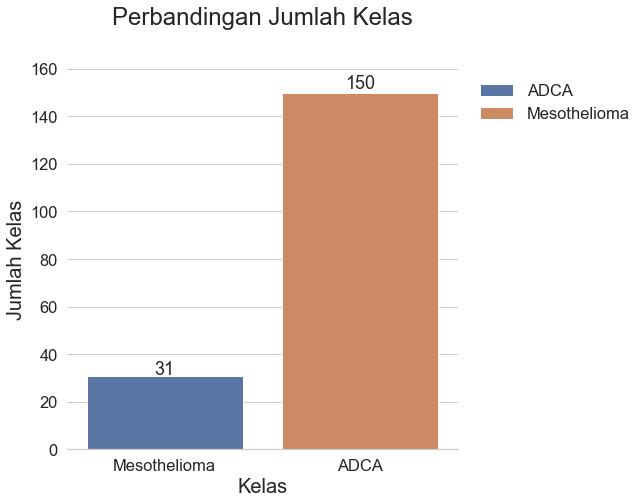

In [7]:
plt.figure(figsize=(7,7))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
p = sns.countplot(x=df.Class, hue=df.Class, dodge=False, data=df)
sns.despine(left=True)
p.set_title('Perbandingan Jumlah Kelas', fontsize=24, y=1.1)
p.set_ylabel('Jumlah Kelas', fontsize=20)
p.set_xlabel('Kelas', fontsize=20)
p.set_ylim(0, 160)
# plt.legend(labels=['Tumor', 'Normal'], frameon=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', labels=['ADCA', 'Mesothelioma'], frameon=False)
show_values(p, fmt='{:.0f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/JumlahClass.png', legend=p.get_legend)

In [8]:
#encode
encode = LabelEncoder()
df['Class'] = encode.fit_transform(df['Class'])
df.Class.value_counts()

0    150
1     31
Name: Class, dtype: int64

In [9]:
class_names = np.unique(df.Class)
class_names

array([0, 1])

In [10]:
X = df.drop(columns='Class').values
y = df.Class.values
print(Counter(y))

Counter({0: 150, 1: 31})


In [11]:
#normalisasi
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X)

0         1         2         3         4         5         6      \
0    0.375179  0.287532  0.269049  0.360570  0.636456  0.215852  0.066397   
1    0.356250  0.507888  0.233307  0.493025  0.580253  0.182073  0.142621   
2    0.526964  0.271756  0.195994  0.275793  0.487089  0.205825  0.087795   
3    0.384821  0.194402  0.309898  0.293730  0.562532  0.058880  0.098356   
4    0.400179  0.590840  0.396308  0.516940  0.993418  0.323299  0.093764   
..        ...       ...       ...       ...       ...       ...       ...   
176  0.413750  0.471756  0.324038  0.341714  0.702278  0.281513  0.116631   
177  0.287679  0.193893  0.168500  0.189330  0.724557  0.017707  0.126733   
178  0.490357  0.300763  0.230558  0.263222  0.865316  0.025999  0.099734   
179  0.423393  0.271756  0.200707  0.319025  0.698734  0.200576  0.093489   
180  0.526607  0.375573  0.257659  0.275487  0.661266  0.150253  0.120672   

        7         8         9      ...     12523     12524     12525  \
0    0.515220  0.008949  0.653018  ...  0.616359  0.310935  0.382253   
1    0.192192  0.102424  0.451735  ...  0.507781  0.346976  0.228669   
2    0.386159  0.016538  0.356520  ...  0.467608  0.339035  0.540273   
3    0.467513  0.005679  0.558406  ...  0.551936  0.373855  0.402730   
4    0.505665  0.203594  0.413364  ...  0.356858  0.348198  0.574061   
..        ...       ...       ...  ...       ...       ...       ...   
176  0.269247  0.000697  0.330647  ...  0.514658  0.412340  0.565529   
177  0.822413  0.019463  0.844598  ...  0.359030  0.432498  0.436519   
178  0.467513  0.018134  0.681138  ...  0.345277  0.309102  0.486348   
179  0.299823  0.006564  0.308557  ...  0.460369  0.314600  0.427304   
180  0.411616  0.012806  0.556871  ...  0.433949  0.315822  0.516382   

        12526     12527     12528     12529     12530     12531     12532  
0    0.749164  0.784075  0.349858  0.187671  0.151194  0.654613  0.517198  
1    0.723523  0.584197  0.357649  0.229809  0.140308  0.573747  0.560365  
2    0.476031  0.524883  0.276558  0.228248  0.485183  0.664009  0.421630  
3    0.773690  0.817388  0.290368  0.187281  0.103417  0.624431  0.463527  
4    0.740245  0.507820  0.135977  0.132657  0.190656  0.616173  0.314404  
..        ...       ...       ...       ...       ...       ...       ...  
176  0.628763  0.853138  0.398371  0.511120  0.127910  0.664579  0.444137  
177  0.363434  0.695105  0.147309  0.088958  0.122921  0.769362  0.435942  
178  0.691193  0.738168  0.513810  0.506048  0.122770  0.734624  0.435596  
179  0.614270  0.541133  0.337819  0.471323  0.096008  0.677392  0.902008  
180  0.566332  0.719277  0.268059  0.158798  0.104475  0.699886  0.552632  

[181 rows x 12533 columns]

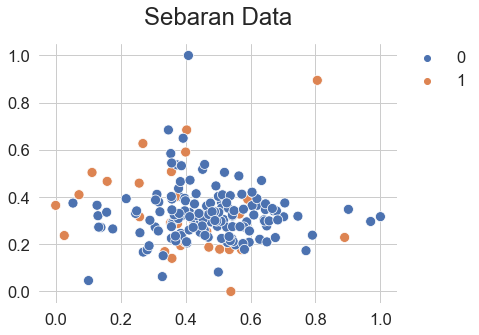

In [12]:
plt.figure(figsize=(7, 5))
plt.rcParams['figure.autolayout'] = True
sns.set_style('whitegrid')
p = sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, s=100)
p.set_title('Sebaran Data', fontsize=24, y=1.05)
sns.despine(left=True, bottom=True)
p_fig = p.get_figure()
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/ScatterPlot.png')

# SELEKSI FITUR

## Fold 2-10

In [311]:
fs_mdl = np.zeros(11)
fs_acc = np.zeros(11)
fs_prc = np.zeros(11)
fs_rcl = np.zeros(11)
fs_f1 = np.zeros(11)
ftr = np.zeros(11)
fs_pos = []
fs_pred = []
fs_act = []

X_train_fold = []
y_train_fold = []
X_test_fold = []
y_test_fold = []

for a in range(2, 11):
    print("FOLD :", a)

    #split menggunakan kfold
    folds = StratifiedKFold(n_splits=a, shuffle=True, random_state=42)

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for train_index, test_index in folds.split(X, y):
        X_train.append(X[train_index]), X_test.append(X[test_index]), y_train.append(y[train_index]), y_test.append(y[test_index])

    for i in range(folds.n_splits):
        print(Counter(y_train[i]))

    X_train_fold.append(X_train)
    y_train_fold.append(y_train)
    X_test_fold.append(X_test)
    y_test_fold.append(y_test)

    #modeling
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    #seleksi fitur BPSO
    def f_per_particle(m, alpha):
        total_features = X.shape[1]
        scores = np.zeros(folds.n_splits)

        for i in range(folds.n_splits):
            if np.count_nonzero(m) == 0:
                X_subset = X_train[i]
            else:
                X_subset = X_train[i][:,m==1]

            model.fit(X_subset, y_train[i])
            pred = model.predict(X_subset)
            scores[i] = accuracy_score(y_train[i], pred)

        P = np.mean(scores)

        j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
        return j

    def f(x, alpha=0.88):
        n_particles = x.shape[0]
        j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
        return np.array(j)

    #inisiasiBPSO
    ps.discrete.BinaryPSO

    #executeBPSO
    options = {'c1': 2, 'c2': 2, 'w':0.9, 'k': 30, 'p':2}
    dimensions = X.shape[1]
    optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
    cost, pos = optimizer.optimize(f, iters=10, verbose=3)

    fs_pos.append(pos)

    #model
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    mdl_scr = np.zeros(folds.n_splits)
    acc_scr = np.zeros(folds.n_splits)
    prc_scr = np.zeros(folds.n_splits)
    rcl_scr = np.zeros(folds.n_splits)
    f1_scr = np.zeros(folds.n_splits)
    pred_scr = []
    act_scr = []

    for i in range(folds.n_splits):
        X_train_selected = X_train[i][:,pos==1]
        X_test_selected = X_test[i][:,pos==1]

        #fit
        model.fit(X_train_selected, y_train[i])

        #predict
        pred = model.predict(X_test_selected)
        pred_scr.append(pred)
        act_scr.append(y_test[i])

        #accuracy
        mdl_scr[i] = model.score(X_train_selected, y_train[i])
        acc_scr[i] = accuracy_score(y_test[i], pred)
        prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
        rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
        f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)


    #collect acc, prc, rcl, f1 BPSO
    fs_mdl[a-1] = np.mean(mdl_scr)
    fs_acc[a-1] = np.mean(acc_scr)
    fs_prc[a-1] = np.mean(prc_scr)
    fs_rcl[a-1] = np.mean(rcl_scr)
    fs_f1[a-1] = np.mean(f1_scr)
    ftr[a-1] = np.count_nonzero(pos)
    fs_pred.append(pred_scr)
    fs_act.append(act_scr)    


ind_fs = np.argmax(fs_acc)
# ind = np.argmax(n_acc)
print('---------- BPSO ----------')
print('Fold : ', ind_fs+1)
print('Accuracy Model : %0.4f'%(fs_mdl[ind_fs]))
print('Mean Accuracy: %0.4f'%(np.max(fs_acc)))
print('Mean Precision: %0.4f'%(fs_prc[ind_fs]))
print('Mean Recall: %0.4f'%(fs_rcl[ind_fs]))
print('Mean F1: %0.4f'%(fs_f1[ind_fs]))

FOLD : 2


2022-07-19 21:47:57,128 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Counter({0: 75, 1: 15})
Counter({0: 75, 1: 16})


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.057
2022-07-19 21:48:06,330 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057017473868985875, best pos: [1 1 1 ... 1 1 0]
2022-07-19 21:48:06,471 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 3
Counter({0: 100, 1: 20})
Counter({0: 100, 1: 21})
Counter({0: 100, 1: 21})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-19 21:48:22,950 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057189818878161644, best pos: [1 0 1 ... 0 1 0]
2022-07-19 21:48:23,156 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 4
Counter({0: 112, 1: 23})
Counter({0: 113, 1: 23})
Counter({0: 113, 1: 23})
Counter({0: 112, 1: 24})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0571
2022-07-19 21:48:47,385 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057122795819037744, best pos: [0 1 0 ... 1 1 0]
2022-07-19 21:48:47,656 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 5
Counter({0: 120, 1: 24})
Counter({0: 120, 1: 25})
Counter({0: 120, 1: 25})
Counter({0: 120, 1: 25})
Counter({0: 120, 1: 25})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 21:49:19,539 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0579270725285247, best pos: [1 1 0 ... 1 0 0]
2022-07-19 21:49:19,855 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 6
Counter({0: 125, 1: 25})
Counter({0: 125, 1: 26})
Counter({0: 125, 1: 26})
Counter({0: 125, 1: 26})
Counter({0: 125, 1: 26})
Counter({0: 125, 1: 26})


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-19 21:50:00,635 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0579940955876486, best pos: [0 0 0 ... 0 0 1]
2022-07-19 21:50:01,031 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 7
Counter({0: 129, 1: 26})
Counter({0: 129, 1: 26})
Counter({0: 129, 1: 26})
Counter({0: 128, 1: 27})
Counter({0: 128, 1: 27})
Counter({0: 128, 1: 27})
Counter({0: 129, 1: 27})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-19 21:50:49,062 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05740046277826538, best pos: [1 0 0 ... 0 0 1]
2022-07-19 21:50:49,490 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 8
Counter({0: 131, 1: 27})
Counter({0: 131, 1: 27})
Counter({0: 131, 1: 27})
Counter({0: 131, 1: 27})
Counter({0: 131, 1: 27})
Counter({0: 132, 1: 27})
Counter({0: 132, 1: 27})
Counter({0: 131, 1: 28})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-19 21:51:45,441 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05759195723290513, best pos: [0 1 1 ... 1 0 0]
2022-07-19 21:51:45,913 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

FOLD : 9
Counter({0: 133, 1: 27})
Counter({0: 134, 1: 27})
Counter({0: 134, 1: 27})
Counter({0: 134, 1: 27})
Counter({0: 133, 1: 28})
Counter({0: 133, 1: 28})
Counter({0: 133, 1: 28})
Counter({0: 133, 1: 28})
Counter({0: 133, 1: 28})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-19 21:52:49,643 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05755365834197718, best pos: [1 0 1 ... 1 0 1]
2022-07-19 21:52:50,155 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}


FOLD : 10
Counter({0: 135, 1: 27})
Counter({0: 135, 1: 28})
Counter({0: 135, 1: 28})
Counter({0: 135, 1: 28})
Counter({0: 135, 1: 28})
Counter({0: 135, 1: 28})
Counter({0: 135, 1: 28})
Counter({0: 135, 1: 28})
Counter({0: 135, 1: 28})
Counter({0: 135, 1: 28})


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-19 21:54:02,796 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057706853905688985, best pos: [1 0 0 ... 1 0 1]


---------- BPSO ----------
Fold :  8
Accuracy Model : 1.0000
Mean Accuracy: 0.9563
Mean Precision: 0.9509
Mean Recall: 1.0000
Mean F1: 0.9745


Confusion matrix, without normalization


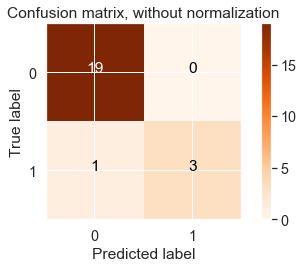

Confusion matrix, without normalization


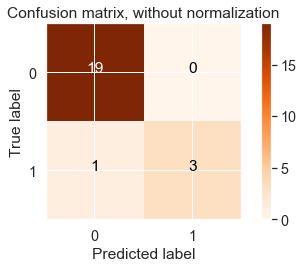

Confusion matrix, without normalization


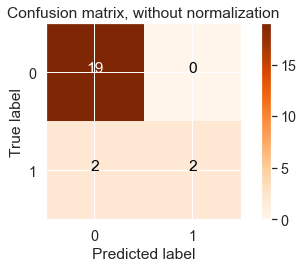

Confusion matrix, without normalization


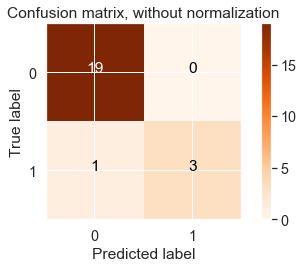

Confusion matrix, without normalization


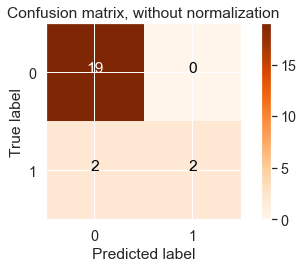

Confusion matrix, without normalization


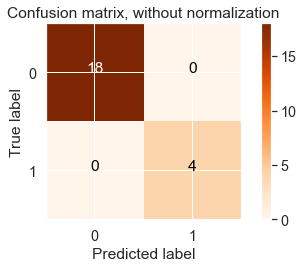

Confusion matrix, without normalization


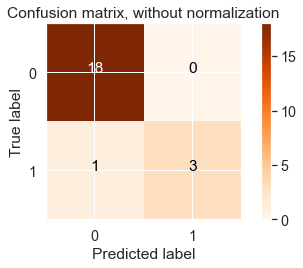

Confusion matrix, without normalization


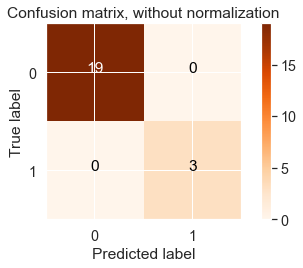

In [312]:
for i in range(ind_fs+1):
    plot_confusion_matrix(fs_pred[ind_fs-1][i], fs_act[ind_fs-1][i])

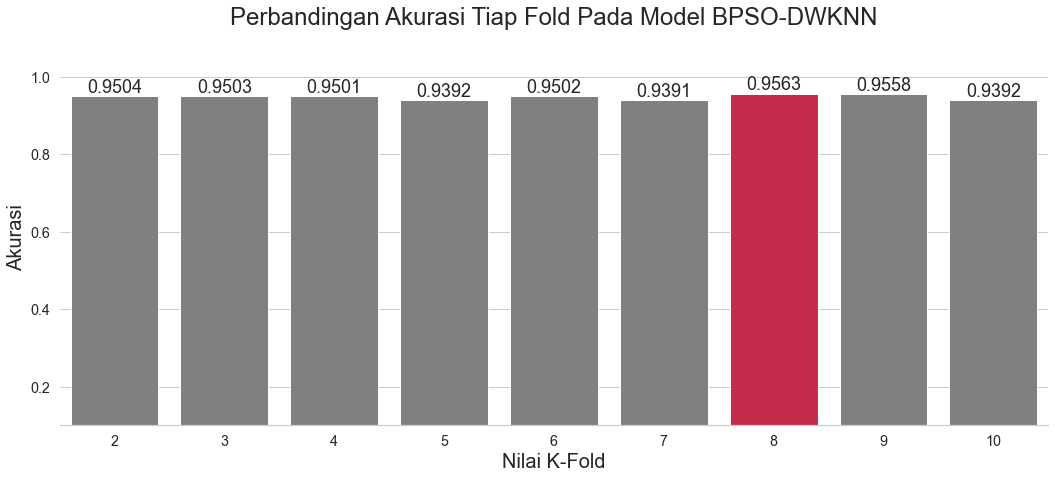

In [313]:
fold = [2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(15,7))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
clr = ['grey' if (x < max(fs_acc[1:10])) else 'crimson' for x in fs_acc[1:10]]
p = sns.barplot(x=fold, y=fs_acc[1:10], palette=clr)
sns.despine(left=True)
p.set_title('Perbandingan Akurasi Tiap Fold Pada Model BPSO-DWKNN', fontsize=24, y=1.05)
p.set_xlabel("Nilai K-Fold", fontsize = 20)
p.set_ylabel("Akurasi", fontsize = 20)
p.set_ylim(0.1, 1.07)
sns.set(font_scale=1.5)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/FoldWithBPSO.png')

In [394]:
fld = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]
fold_fs_df = pd.DataFrame({'Fold': fld[1:10],
                       'AkurasiTrain': np.round(fs_mdl[1:10], 4),
                      'AkurasiTest': np.round(fs_acc[1:10], 4),
                      'Presisi': np.round(fs_prc[1:10], 4),
                      'Recall': np.round(fs_rcl[1:10], 4),
                      'F1-Score': np.round(fs_f1[1:10], 4),
                           'JumlahFitur': ftr[1:10],
                      })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

fold_fs_df.style.set_table_styles(dfstyle).hide_index()

In [315]:
fs_pos_df = pd.DataFrame(fs_pos)
fs_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/LungFoldPOS.csv')

## Pembagian Data

In [344]:
X_train = X_train_fold[ind_fs-1]
y_train = y_train_fold[ind_fs-1] 
X_test =  X_test_fold[ind_fs-1]
y_test = y_test_fold[ind_fs-1]

print(len(X_train), len(y_train), len(X_test), len(y_test))

8 8 8 8


## C1, C2, W

In [317]:
#modeling
model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')
splits = ind_fs+1

#seleksi fitur BPSO
def f_per_particle(m, alpha):
    total_features = X.shape[1]
    scores = np.zeros(splits)

    for i in range(splits):
        if np.count_nonzero(m) == 0:
            X_subset = X_train[i]
        else:
            X_subset = X_train[i][:,m==1]

        model.fit(X_subset, y_train[i])
        pred = model.predict(X_subset)
        scores[i] = accuracy_score(y_train[i], pred)

    P = np.mean(scores)

    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

def f(x, alpha=0.88):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

w = 0.9
c1 = [1, 1.25, 1.5, 1.75, 2]
c2 = [1, 1.25, 1.5, 1.75, 2]
wth, hgh = 5, 5
w0_acc = [[0 for x in range(wth)] for y in range(hgh)] 
w1_acc = [[0 for x in range(wth)] for y in range(hgh)] 
c1c2_pos = []
for it in range(2):
    m = 0
    for _c1 in range(len(c1)):
        n = 0
        for _c2 in range(len(c2)):
                #inisiasiBPSO
                ps.discrete.BinaryPSO

                #executeBPSO
                options = {'c1': c1[_c1], 'c2': c2[_c2], 'w':w, 'k': 30, 'p':2}
                dimensions = X.shape[1]
                optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
                cost, pos = optimizer.optimize(f, iters=10, verbose=3)
                
                c1c2_pos.append(pos)
                
                #model
                model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

                mdl_scr = np.zeros(splits)
                acc_scr = np.zeros(splits)
                prc_scr = np.zeros(splits)
                rcl_scr = np.zeros(splits)
                f1_scr = np.zeros(splits)

                for i in range(splits):
                    X_train_selected = X_train[i][:,pos==1]
                    X_test_selected = X_test[i][:,pos==1]

                    #fit
                    model.fit(X_train_selected, y_train[i])

                    #predict
                    pred = model.predict(X_test_selected)

                    #accuracy
                    mdl_scr[i] = model.score(X_train_selected, y_train[i])
                    acc_scr[i] = accuracy_score(y_test[i], pred)
                    prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
                    rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
                    f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)
                if w == 0.9:
                    w0_acc[m][n] = np.round(np.mean(acc_scr), 4)
                else:
                    w1_acc[m][n] = np.round(np.mean(acc_scr), 4)
                n+=1
                print('c1 = ', c1[_c1], 'c2 = ', c2[_c2], 'w = ', w)
                print('Dengan Seleksi Fitur BPSO')
                print('Model:', np.round(np.mean(mdl_scr),4), '\t', 'Acc: ', np.round(np.mean(acc_scr),4), '\t', 'Presisi: ', np.round(np.mean(prc_scr),4), '\t', 'Recall:', np.round(np.mean(rcl_scr),4), '\t', 'F1 Score:', np.round(np.mean(f1_scr),4), '\t', 'Fitur Terpilih:', np.count_nonzero(pos))
        m+=1
    w+=0.1

2022-07-19 21:54:09,238 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-19 21:55:04,700 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05809941753770047, best pos: [0 1 1 ... 0 0 1]
2022-07-19 21:55:05,030 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9454 	 Presisi:  0.9401 	 Recall: 1.0 	 F1 Score: 0.9686 	 Fitur Terpilih: 6465


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0583
2022-07-19 21:56:00,927 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05829091199234022, best pos: [1 0 1 ... 1 0 0]
2022-07-19 21:56:01,272 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9617 	 Presisi:  0.9565 	 Recall: 1.0 	 F1 Score: 0.9776 	 Fitur Terpilih: 6445


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 21:56:57,172 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057850474746668795, best pos: [0 1 1 ... 0 0 1]
2022-07-19 21:56:57,515 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.956 	 Presisi:  0.9503 	 Recall: 1.0 	 F1 Score: 0.9743 	 Fitur Terpilih: 6491


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-19 21:57:53,541 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05796537141945265, best pos: [1 1 0 ... 0 1 0]
2022-07-19 21:57:53,886 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9454 	 Presisi:  0.941 	 Recall: 1.0 	 F1 Score: 0.9689 	 Fitur Terpilih: 6479


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 21:58:49,899 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05788877363759675, best pos: [0 0 1 ... 0 0 1]
2022-07-19 21:58:50,228 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9617 	 Presisi:  0.9571 	 Recall: 1.0 	 F1 Score: 0.9777 	 Fitur Terpilih: 6487


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-19 21:59:46,196 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058003670310380596, best pos: [1 0 1 ... 0 1 1]
2022-07-19 21:59:46,531 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9397 	 Presisi:  0.9333 	 Recall: 1.0 	 F1 Score: 0.9652 	 Fitur Terpilih: 6475


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 22:00:42,303 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05787919891486475, best pos: [1 1 0 ... 1 1 0]
2022-07-19 22:00:42,627 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9615 	 Presisi:  0.9628 	 Recall: 0.9934 	 F1 Score: 0.9774 	 Fitur Terpilih: 6488


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-19 22:01:38,612 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05819516476502034, best pos: [0 0 0 ... 0 1 1]
2022-07-19 22:01:38,945 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9617 	 Presisi:  0.9565 	 Recall: 1.0 	 F1 Score: 0.9776 	 Fitur Terpilih: 6455


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-19 22:02:34,867 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057505784728317244, best pos: [1 0 0 ... 0 0 1]
2022-07-19 22:02:35,222 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9454 	 Presisi:  0.941 	 Recall: 1.0 	 F1 Score: 0.9689 	 Fitur Terpilih: 6527


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0572
2022-07-19 22:03:31,489 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0572376924918216, best pos: [0 0 0 ... 0 0 0]
2022-07-19 22:03:31,852 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9343 	 Presisi:  0.9291 	 Recall: 1.0 	 F1 Score: 0.9626 	 Fitur Terpilih: 6555


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-19 22:04:27,463 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05748663528285326, best pos: [1 0 0 ... 0 1 0]
2022-07-19 22:04:27,789 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9452 	 Presisi:  0.939 	 Recall: 1.0 	 F1 Score: 0.9683 	 Fitur Terpilih: 6529


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-19 22:05:23,587 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05802281975584457, best pos: [1 1 1 ... 1 1 1]
2022-07-19 22:05:23,913 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9397 	 Presisi:  0.941 	 Recall: 0.9934 	 F1 Score: 0.9655 	 Fitur Terpilih: 6473


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-19 22:06:20,223 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057831325301204814, best pos: [1 1 1 ... 1 0 0]
2022-07-19 22:06:20,554 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9289 	 Presisi:  0.9235 	 Recall: 1.0 	 F1 Score: 0.9596 	 Fitur Terpilih: 6493


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-19 22:07:16,268 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05819516476502034, best pos: [0 0 1 ... 1 1 1]
2022-07-19 22:07:16,600 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9452 	 Presisi:  0.939 	 Recall: 1.0 	 F1 Score: 0.9683 	 Fitur Terpilih: 6455


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-19 22:08:12,683 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0576206814011011, best pos: [0 1 0 ... 1 0 1]
2022-07-19 22:08:13,021 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9397 	 Presisi:  0.9333 	 Recall: 1.0 	 F1 Score: 0.9652 	 Fitur Terpilih: 6515


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-19 22:09:08,694 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05810899226043245, best pos: [1 1 1 ... 0 1 1]
2022-07-19 22:09:09,029 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9617 	 Presisi:  0.9565 	 Recall: 1.0 	 F1 Score: 0.9776 	 Fitur Terpilih: 6464


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-19 22:10:05,188 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05773557807388495, best pos: [0 0 1 ... 0 1 1]
2022-07-19 22:10:05,515 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9563 	 Presisi:  0.9509 	 Recall: 1.0 	 F1 Score: 0.9745 	 Fitur Terpilih: 6503


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-19 22:11:01,440 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058243038378680285, best pos: [0 0 0 ... 0 1 1]
2022-07-19 22:11:01,781 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9449 	 Presisi:  0.9443 	 Recall: 0.9934 	 F1 Score: 0.9679 	 Fitur Terpilih: 6450


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-19 22:11:57,591 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05771642862842097, best pos: [1 1 0 ... 0 0 0]
2022-07-19 22:11:57,930 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9452 	 Presisi:  0.939 	 Recall: 1.0 	 F1 Score: 0.9683 	 Fitur Terpilih: 6505


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0575
2022-07-19 22:12:53,687 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0575345088965132, best pos: [1 1 0 ... 0 0 0]
2022-07-19 22:12:54,042 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9506 	 Presisi:  0.9446 	 Recall: 1.0 	 F1 Score: 0.9713 	 Fitur Terpilih: 6524


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 22:13:50,079 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05794622197398867, best pos: [1 1 1 ... 1 1 0]
2022-07-19 22:13:50,404 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.25, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9454 	 Presisi:  0.9401 	 Recall: 1.0 	 F1 Score: 0.9686 	 Fitur Terpilih: 6481


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-19 22:14:46,006 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05823346365594829, best pos: [1 1 0 ... 0 0 1]
2022-07-19 22:14:46,344 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.25 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9563 	 Presisi:  0.9509 	 Recall: 1.0 	 F1 Score: 0.9745 	 Fitur Terpilih: 6451


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-19 22:15:42,392 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05821431421048432, best pos: [0 1 1 ... 0 1 0]
2022-07-19 22:15:42,723 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.75, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.5 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9617 	 Presisi:  0.9565 	 Recall: 1.0 	 F1 Score: 0.9776 	 Fitur Terpilih: 6453


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 22:16:38,548 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05790792308306072, best pos: [1 0 0 ... 1 0 0]
2022-07-19 22:16:38,876 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.75 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9449 	 Presisi:  0.9443 	 Recall: 0.9934 	 F1 Score: 0.9679 	 Fitur Terpilih: 6485


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-19 22:17:34,886 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05755365834197718, best pos: [0 1 1 ... 1 0 1]
2022-07-19 22:17:35,229 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  2 w =  0.9
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9503 	 Presisi:  0.9499 	 Recall: 0.9934 	 F1 Score: 0.971 	 Fitur Terpilih: 6522


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-19 22:18:30,732 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05820473948775234, best pos: [0 0 0 ... 1 0 1]
2022-07-19 22:18:31,056 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9454 	 Presisi:  0.9401 	 Recall: 1.0 	 F1 Score: 0.9686 	 Fitur Terpilih: 6454


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 22:19:26,924 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05794622197398867, best pos: [0 0 0 ... 1 0 0]
2022-07-19 22:19:27,248 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9452 	 Presisi:  0.939 	 Recall: 1.0 	 F1 Score: 0.9683 	 Fitur Terpilih: 6481


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 22:20:23,011 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057850474746668795, best pos: [0 0 0 ... 0 0 1]
2022-07-19 22:20:23,337 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9671 	 Presisi:  0.9628 	 Recall: 1.0 	 F1 Score: 0.9808 	 Fitur Terpilih: 6491


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-19 22:21:19,212 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05759195723290513, best pos: [0 1 0 ... 0 1 1]
2022-07-19 22:21:19,551 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9508 	 Presisi:  0.9457 	 Recall: 1.0 	 F1 Score: 0.9716 	 Fitur Terpilih: 6518


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-19 22:22:15,567 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05755365834197718, best pos: [1 1 0 ... 0 0 0]
2022-07-19 22:22:15,892 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9671 	 Presisi:  0.9622 	 Recall: 1.0 	 F1 Score: 0.9806 	 Fitur Terpilih: 6522


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-19 22:23:11,517 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058003670310380596, best pos: [0 1 1 ... 1 0 0]
2022-07-19 22:23:11,851 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.956 	 Presisi:  0.9503 	 Recall: 1.0 	 F1 Score: 0.9743 	 Fitur Terpilih: 6475


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0574
2022-07-19 22:24:08,137 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057448336391925314, best pos: [1 0 1 ... 1 0 1]
2022-07-19 22:24:08,487 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9452 	 Presisi:  0.9395 	 Recall: 1.0 	 F1 Score: 0.9684 	 Fitur Terpilih: 6533


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-19 22:25:04,092 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05806111864677252, best pos: [0 0 1 ... 0 0 0]
2022-07-19 22:25:04,426 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9563 	 Presisi:  0.9509 	 Recall: 1.0 	 F1 Score: 0.9745 	 Fitur Terpilih: 6469


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 22:26:00,517 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05794622197398867, best pos: [1 1 1 ... 1 0 1]
2022-07-19 22:26:00,855 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.25, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9506 	 Presisi:  0.9446 	 Recall: 1.0 	 F1 Score: 0.9713 	 Fitur Terpilih: 6481


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-19 22:26:59,359 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05774515279661693, best pos: [0 1 1 ... 0 0 0]
2022-07-19 22:26:59,759 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.25 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9617 	 Presisi:  0.9565 	 Recall: 1.0 	 F1 Score: 0.9776 	 Fitur Terpilih: 6502


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0583
2022-07-19 22:27:57,154 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058281337269608234, best pos: [1 1 0 ... 0 1 1]
2022-07-19 22:27:57,483 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9508 	 Presisi:  0.9457 	 Recall: 1.0 	 F1 Score: 0.9716 	 Fitur Terpilih: 6446


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-19 22:28:53,494 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05766855501476103, best pos: [1 1 0 ... 1 1 1]
2022-07-19 22:28:53,825 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9397 	 Presisi:  0.9348 	 Recall: 1.0 	 F1 Score: 0.9656 	 Fitur Terpilih: 6510


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-19 22:29:49,832 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057706853905688985, best pos: [0 0 0 ... 1 1 0]
2022-07-19 22:29:50,198 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9449 	 Presisi:  0.9443 	 Recall: 0.9934 	 F1 Score: 0.9679 	 Fitur Terpilih: 6506


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-19 22:30:46,036 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057639830846565064, best pos: [0 0 0 ... 1 0 0]
2022-07-19 22:30:46,383 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9617 	 Presisi:  0.9565 	 Recall: 1.0 	 F1 Score: 0.9776 	 Fitur Terpilih: 6513


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-19 22:31:42,537 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05763025612383308, best pos: [0 1 1 ... 0 1 1]
2022-07-19 22:31:42,866 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.5 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9617 	 Presisi:  0.9565 	 Recall: 1.0 	 F1 Score: 0.9776 	 Fitur Terpilih: 6514


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-19 22:32:38,462 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05817601531955637, best pos: [0 0 1 ... 0 0 1]
2022-07-19 22:32:38,812 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9395 	 Presisi:  0.9386 	 Recall: 0.9934 	 F1 Score: 0.9649 	 Fitur Terpilih: 6457


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 22:33:34,836 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.0579174978057927, best pos: [0 1 0 ... 1 0 1]
2022-07-19 22:33:35,166 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9452 	 Presisi:  0.9395 	 Recall: 1.0 	 F1 Score: 0.9684 	 Fitur Terpilih: 6484


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0577
2022-07-19 22:34:30,820 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05771642862842097, best pos: [1 0 1 ... 0 0 0]
2022-07-19 22:34:31,148 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9343 	 Presisi:  0.9291 	 Recall: 1.0 	 F1 Score: 0.9626 	 Fitur Terpilih: 6505


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 22:35:27,000 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057850474746668795, best pos: [1 1 0 ... 1 0 1]
2022-07-19 22:35:27,333 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.75, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.956 	 Presisi:  0.9503 	 Recall: 1.0 	 F1 Score: 0.9743 	 Fitur Terpilih: 6491


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-19 22:36:23,449 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05801324503311259, best pos: [1 1 0 ... 1 0 1]
2022-07-19 22:36:23,793 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  1.75 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9452 	 Presisi:  0.939 	 Recall: 1.0 	 F1 Score: 0.9683 	 Fitur Terpilih: 6474


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-19 22:37:19,676 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.057984520864916615, best pos: [0 1 0 ... 0 0 0]
2022-07-19 22:37:20,015 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.25, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9617 	 Presisi:  0.9565 	 Recall: 1.0 	 F1 Score: 0.9776 	 Fitur Terpilih: 6477


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-19 22:38:15,927 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05810899226043245, best pos: [1 0 0 ... 0 1 0]
2022-07-19 22:38:16,261 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.5, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.25 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.956 	 Presisi:  0.9503 	 Recall: 1.0 	 F1 Score: 0.9743 	 Fitur Terpilih: 6464


pyswarms.discrete.binary: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=0.058
2022-07-19 22:39:11,948 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05804196920130855, best pos: [1 1 1 ... 0 1 1]
2022-07-19 22:39:12,282 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 1.75, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.5 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.956 	 Presisi:  0.9503 	 Recall: 1.0 	 F1 Score: 0.9743 	 Fitur Terpilih: 6471


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0582
2022-07-19 22:40:08,481 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05823346365594829, best pos: [0 0 1 ... 0 1 1]
2022-07-19 22:40:08,807 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 1.0, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

c1 =  2 c2 =  1.75 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9563 	 Presisi:  0.9515 	 Recall: 1.0 	 F1 Score: 0.9747 	 Fitur Terpilih: 6451


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0579
2022-07-19 22:41:04,520 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05787919891486475, best pos: [1 0 1 ... 0 0 1]


c1 =  2 c2 =  2 w =  1.0
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9617 	 Presisi:  0.9565 	 Recall: 1.0 	 F1 Score: 0.9776 	 Fitur Terpilih: 6488


In [318]:
w0_df = pd.DataFrame(w0_acc)
w0_df.columns = ['1', '1.25', '1.5', '1.75', '2']
w0_df.index = ['1', '1.25', '1.5', '1.75', '2']

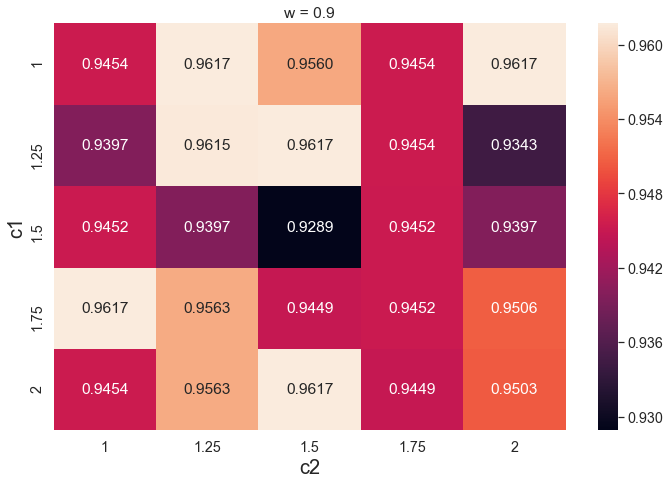

In [319]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
par_w0 = sns.heatmap(xticklabels=c2, yticklabels=c1, data=w0_acc, annot=True, fmt='.4f')
ft = {
    'fontsize':20,
    'fontweight':20,
}
par_w0.set_title(label= 'w = 0.9');
par_w0.set_xlabel('c2', fontdict=ft)
par_w0.set_ylabel('c1', fontdict=ft)
p_fig = par_w0.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/C1C2W09.png')

In [320]:
# w0_acc.reverse()

In [321]:
w1_df = pd.DataFrame(w1_acc)
w1_df.columns = ['1', '1.25', '1.5', '1.75', '2']
w1_df.index = ['1', '1.25', '1.5', '1.75', '2']

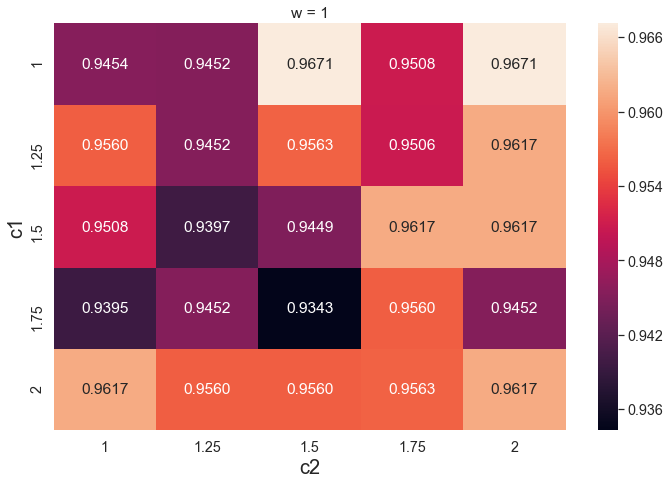

In [322]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
par_w1 = sns.heatmap(xticklabels=c2, yticklabels=c1, data=w1_acc, annot=True, fmt='.4f')
ft = {
    'fontsize':20,
    'fontweight':20,
}
par_w1.set_title(label= 'w = 1');
par_w1.set_xlabel('c2', fontdict=ft)
par_w1.set_ylabel('c1', fontdict=ft)
p_fig = par_w1.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/C1C2W1.png')

In [323]:
c1c2_pos_df = pd.DataFrame(c1c2_pos)
c1c2_pos_df
c1c2_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/LungC1C2POS.csv')

## Population

In [345]:
#modeling
model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

#seleksi fitur BPSO
def f_per_particle(m, alpha):
    total_features = X.shape[1]
    scores = np.zeros(splits)

    for i in range(splits):
        if np.count_nonzero(m) == 0:
            X_subset = X_train[i]
        else:
            X_subset = X_train[i][:,m==1]

        model.fit(X_subset, y_train[i])
        pred = model.predict(X_subset)
        scores[i] = accuracy_score(y_train[i], pred)

    P = np.mean(scores)

    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

def f(x, alpha=0.88):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

prt = [10, 20, 30, 50]

pop_mdl = np.zeros(len(prt))
pop_acc = np.zeros(len(prt))
pop_prc = np.zeros(len(prt))
pop_rcl = np.zeros(len(prt))
pop_f1 = np.zeros(len(prt))
pop_pos = []

for k in range(len(prt)):
    #inisiasiBPSO
    ps.discrete.BinaryPSO

    #executeBPSO
    options = {'c1': 1, 'c2': 1.5, 'w': 1, 'k': prt[k], 'p':2}
    dimensions = X.shape[1]
    optimizer = ps.discrete.BinaryPSO(n_particles=prt[k], dimensions=dimensions, options=options, velocity_clamp=(-6, 6))
    cost, pos = optimizer.optimize(f, iters=10, verbose=3)

    pop_pos.append(pos)

    #model
    model = DistanceWeightedKNN(n_neighbors=1, algorithm='brute')

    mdl_scr = np.zeros(splits)
    acc_scr = np.zeros(splits)
    prc_scr = np.zeros(splits)
    rcl_scr = np.zeros(splits)
    f1_scr = np.zeros(splits)

    for i in range(splits):
        X_train_selected = X_train[i][:,pos==1]
        X_test_selected = X_test[i][:,pos==1]

        #fit
        model.fit(X_train_selected, y_train[i])

        #predict
        pred = model.predict(X_test_selected)

        #accuracy
        mdl_scr[i] = model.score(X_train_selected, y_train[i])
        acc_scr[i] = accuracy_score(y_test[i], pred)
        prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
        rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
        f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)

    pop_mdl[k] = np.mean(mdl_scr)
    pop_acc[k] = np.mean(acc_scr)
    pop_prc[k] = np.mean(prc_scr)
    pop_rcl[k] = np.mean(rcl_scr)
    pop_f1[k] = np.mean(f1_scr)   

    print('Population:', prt[k])
    print('Dengan Seleksi Fitur BPSO')
    print('Model:', np.round(np.mean(mdl_scr),4), '\t', 'Acc: ', np.round(np.mean(acc_scr),4), '\t', 'Presisi: ', np.round(np.mean(prc_scr),4), '\t', 'Recall:', np.round(np.mean(rcl_scr),4), '\t', 'F1 Score:', np.round(np.mean(f1_scr),4), '\t', 'Fitur Terpilih:', np.count_nonzero(pos))

2022-07-19 23:42:58,397 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 1, 'k': 10, 'p': 2}
pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0585
2022-07-19 23:43:20,626 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.058472831724247984, best pos: [1 1 0 ... 1 1 0]
2022-07-19 23:43:20,991 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 1, 'k': 20, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 10
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9452 	 Presisi:  0.9395 	 Recall: 1.0 	 F1 Score: 0.9684 	 Fitur Terpilih: 6426


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0581
2022-07-19 23:43:59,728 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05810899226043245, best pos: [1 1 0 ... 1 1 1]
2022-07-19 23:44:00,075 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 1, 'k': 30, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 20
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9671 	 Presisi:  0.9628 	 Recall: 1.0 	 F1 Score: 0.9808 	 Fitur Terpilih: 6464


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0578
2022-07-19 23:44:56,126 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05780260113300885, best pos: [0 0 0 ... 0 0 1]
2022-07-19 23:44:56,468 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 1.5, 'w': 1, 'k': 50, 'p': 2}
pyswarms.discrete.binary:   0%|                                                                                   |0/10

Population: 30
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9452 	 Presisi:  0.9395 	 Recall: 1.0 	 F1 Score: 0.9684 	 Fitur Terpilih: 6496


pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████|10/10, best_cost=0.0576
2022-07-19 23:46:30,097 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.05755365834197718, best pos: [1 0 1 ... 1 0 0]


Population: 50
Dengan Seleksi Fitur BPSO
Model: 1.0 	 Acc:  0.9506 	 Presisi:  0.9509 	 Recall: 0.9934 	 F1 Score: 0.9711 	 Fitur Terpilih: 6522


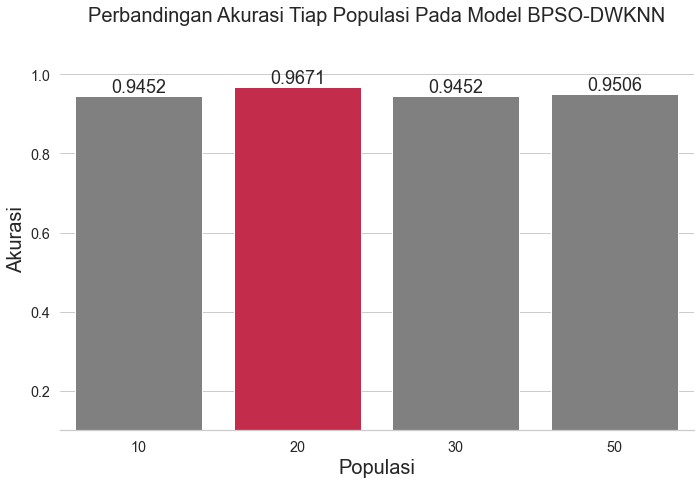

In [346]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
clr = ['grey' if (x < max(pop_acc)) else 'crimson' for x in pop_acc]
p = sns.barplot(x=prt, y=pop_acc, palette=clr)
p.set_title('Perbandingan Akurasi Tiap Populasi Pada Model BPSO-DWKNN', fontsize=20, y=1.05)
sns.despine(left=True)
p.set_xlabel("Populasi", fontsize = 20)
p.set_ylabel("Akurasi", fontsize = 20)
p.set_ylim(0.1, 1.07)
sns.set(font_scale=1.3)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Populasi.png')

In [347]:
pop = [10, 20, 30, 50]
pop_ftr = [np.count_nonzero(pop_pos[0]), np.count_nonzero(pop_pos[1]), np.count_nonzero(pop_pos[2]), np.count_nonzero(pop_pos[3])]
pop_df = pd.DataFrame({'Populasi': pop,
                       'AkurasiTrain': np.round(pop_mdl, 4),
                      'AkurasiTest': np.round(pop_acc, 4),
                      'Presisi': np.round(pop_prc, 4),
                      'Recall': np.round(pop_rcl, 4),
                      'F1-Score': np.round(pop_f1, 4),
                       'JumlahFitur': pop_ftr,
                      })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

pop_df.style.set_table_styles(dfstyle).hide_index()

In [348]:
pop_pos_df = pd.DataFrame(pop_pos)
pop_pos_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/LungPopPOS.csv')

In [349]:
col = df.columns[1:].values
fitur_df = pd.DataFrame(col[pop_pos[1]==1])
fitur_n_df = pd.DataFrame(col[pop_pos[1]==0])
fitur_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/Lung(FiturTerpilih).csv')
fitur_n_df.to_csv('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Pos/Lung(FiturDihapus).csv')

# KLASIFIKASI

In [397]:
kfld_mdl = []
kfld_acc = []
kfld_prc = []
kfld_rcl = []
kfld_f1 = []
kfld_pred = []
kfld_act = []

kfld_d_mdl = []
kfld_d_acc = []
kfld_d_prc = []
kfld_d_rcl = []
kfld_d_f1 = []
kfld_d_pred = []
kfld_d_act = []

In [398]:
print(np.argmax(pop_acc))

for a in range(9):
    print("FOLD :", a+2)
    X_train = X_train_fold[a]
    y_train = y_train_fold[a] 
    X_test =  X_test_fold[a]
    y_test = y_test_fold[a]

    print(len(X_train), len(y_train), len(X_test), len(y_test))
    
    range_k0 = []

    kf_mdl = []
    kf_acc = []
    kf_prc = []
    kf_rcl = []
    kf_f1 = []
    kf_pred = []
    kf_act = []

    kfd_mdl = []
    kfd_acc = []
    kfd_prc = []
    kfd_rcl = []
    kfd_f1 = []
    kfd_pred = []
    kfd_act = []

    for k in range(1, 21):
        
        range_k0.append(k)
        model = DistanceWeightedKNN(n_neighbors=k, algorithm='brute')
        
        # BPSO-DWKNN
        mdl_scr = np.zeros(a+2)
        acc_scr = np.zeros(a+2)
        prc_scr = np.zeros(a+2)
        rcl_scr = np.zeros(a+2)
        f1_scr = np.zeros(a+2)
        
        pred_scr = []
        act_scr = []
        for i in range(a+2):
            
            X_train_selected = X_train[i][:,pop_pos[np.argmax(pop_acc)]==1]
            X_test_selected = X_test[i][:,pop_pos[np.argmax(pop_acc)]==1]

            #fit
            model.fit(X_train_selected, y_train[i])

            #predict
            pred = model.predict(X_test_selected)
            pred_scr.append(pred)
            act_scr.append(y_test[i])

            #accuracy
            mdl_scr[i] = model.score(X_train_selected, y_train[i])
            acc_scr[i] = accuracy_score(y_test[i], pred)
            prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
            rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
            f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)
        
        # DWKNN
        _mdl_scr = np.zeros(a+2)
        _acc_scr = np.zeros(a+2)
        _prc_scr = np.zeros(a+2)
        _rcl_scr = np.zeros(a+2)
        _f1_scr = np.zeros(a+2)
            
        _pred_scr = []
        _act_scr = []
        for i in range(a+2):
            #fit
            model.fit(X_train[i], y_train[i])

            #predict
            pred = model.predict(X_test[i])
            _pred_scr.append(pred)
            _act_scr.append(y_test[i])

            #accuracy
            _mdl_scr[i] = model.score(X_train[i], y_train[i])
            _acc_scr[i] = accuracy_score(y_test[i], pred)
            _prc_scr[i] = precision_score(y_test[i], pred, pos_label=0)
            _rcl_scr[i] = recall_score(y_test[i], pred, pos_label=0)
            _f1_scr[i] = f1_score(y_test[i], pred, pos_label=0)

        # BPSO-DWKNN
        kf_mdl.append(np.round(np.mean(mdl_scr),4))
        kf_acc.append(np.round(np.mean(acc_scr),4))
        kf_prc.append(np.round(np.mean(prc_scr),4))
        kf_rcl.append(np.round(np.mean(rcl_scr),4))
        kf_f1.append(np.round(np.mean(f1_scr),4))
        kf_pred.append(pred_scr)
        kf_act.append(act_scr)

        # DWKNN
        kfd_mdl.append(np.round(np.mean(_mdl_scr),4))
        kfd_acc.append(np.round(np.mean(_acc_scr),4))
        kfd_prc.append(np.round(np.mean(_prc_scr),4))
        kfd_rcl.append(np.round(np.mean(_rcl_scr),4))
        kfd_f1.append(np.round(np.mean(_f1_scr),4))
        kfd_pred.append(_pred_scr)
        kfd_act.append(_act_scr)
    print(len(kfld_acc))
    if len(kfld_acc) < 9:
        # BPSO-DWKNN 
        kfld_mdl.append(kf_mdl)
        kfld_acc.append(kf_acc)
        kfld_prc.append(kf_prc)
        kfld_rcl.append(kf_rcl)
        kfld_f1.append(kf_f1)
        kfld_pred.append(kf_pred)
        kfld_act.append(kf_act)

        # DWKNN
        kfld_d_mdl.append(kfd_mdl)
        kfld_d_acc.append(kfd_acc)
        kfld_d_prc.append(kfd_prc)
        kfld_d_rcl.append(kfd_rcl)
        kfld_d_f1.append(kfd_f1)
        kfld_d_pred.append(kfd_pred)
        kfld_d_act.append(kfd_act)
    else:
        for z in range(len(kf_mdl)):
            # BPSO-DWKNN 
            kfld_mdl[a].append(kf_mdl[z])
            kfld_acc[a].append(kf_acc[z])
            kfld_prc[a].append(kf_prc[z])
            kfld_rcl[a].append(kf_rcl[z])
            kfld_f1[a].append(kf_f1[z])
            kfld_pred[a].append(kf_pred[z])
            kfld_act[a].append(kf_act[z])

            # DWKNN
            kfld_d_mdl[a].append(kfd_mdl[z])
            kfld_d_acc[a].append(kfd_acc[z])
            kfld_d_prc[a].append(kfd_prc[z])
            kfld_d_rcl[a].append(kfd_rcl[z])
            kfld_d_f1[a].append(kfd_f1[z])
            kfld_d_pred[a].append(kfd_pred[z])
            kfld_d_act[a].append(kfd_act[z])

1
FOLD : 2
2 2 2 2
0
FOLD : 3
3 3 3 3
1
FOLD : 4
4 4 4 4
2
FOLD : 5
5 5 5 5
3
FOLD : 6
6 6 6 6
4
FOLD : 7
7 7 7 7
5
FOLD : 8
8 8 8 8
6
FOLD : 9
9 9 9 9
7
FOLD : 10
10 10 10 10
8


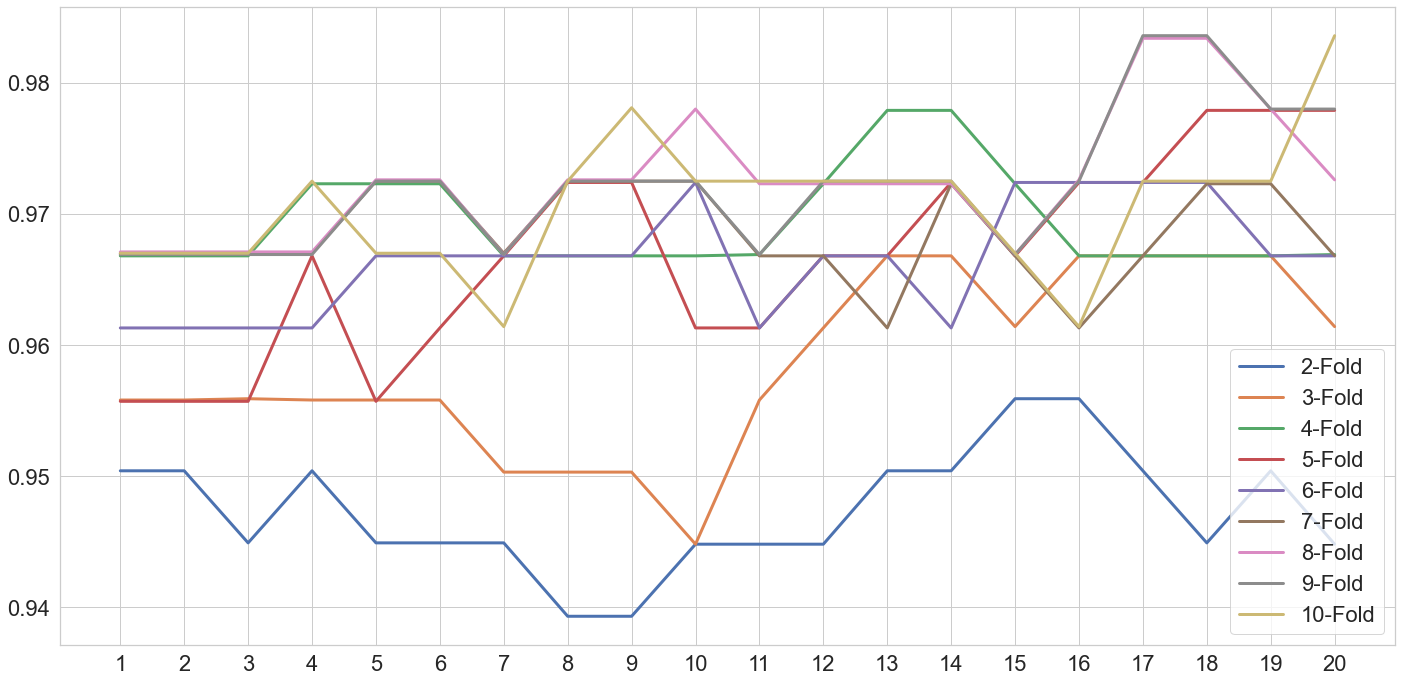

In [400]:
plt.figure(figsize=(20,10))
for i in range(9):
    p = sns.lineplot(range_k0, kfld_acc[i], label='{}-Fold'.format(i+2), linewidth=3)
    p.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [401]:
val_k = []

max_mdl = []
max_akr = []
max_prc = []
max_rcl = []
max_f1 = []
for i in range(9):
    print('FOLD:', i+2, '\t K:', np.argmax(kfld_acc[i])+1, '\t ACC:', np.max(kfld_acc[i]), '\t JUMLAH FITUR:', (np.count_nonzero(pop_pos[np.argmax(pop_acc)])))
    val_k.append(np.argmax(kfld_acc[i])+1)
    max_mdl.append(kfld_mdl[i][np.argmax(kfld_acc[i])])
    max_akr.append(np.max(kfld_acc[i]))
    max_prc.append(kfld_prc[i][np.argmax(kfld_acc[i])])
    max_rcl.append(kfld_rcl[i][np.argmax(kfld_acc[i])])
    max_f1.append(kfld_f1[i][np.argmax(kfld_acc[i])])

FOLD: 2 	 K: 15 	 ACC: 0.9559 	 JUMLAH FITUR: 6464
FOLD: 3 	 K: 13 	 ACC: 0.9668 	 JUMLAH FITUR: 6464
FOLD: 4 	 K: 13 	 ACC: 0.9779 	 JUMLAH FITUR: 6464
FOLD: 5 	 K: 18 	 ACC: 0.9779 	 JUMLAH FITUR: 6464
FOLD: 6 	 K: 10 	 ACC: 0.9724 	 JUMLAH FITUR: 6464
FOLD: 7 	 K: 5 	 ACC: 0.9725 	 JUMLAH FITUR: 6464
FOLD: 8 	 K: 17 	 ACC: 0.9834 	 JUMLAH FITUR: 6464
FOLD: 9 	 K: 17 	 ACC: 0.9836 	 JUMLAH FITUR: 6464
FOLD: 10 	 K: 20 	 ACC: 0.9836 	 JUMLAH FITUR: 6464


In [402]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
bpdw_df = pd.DataFrame({'Fold': fld,
              'Nilai_K': val_k, 
              'AkurasiTrain': max_mdl,
              'AkurasiTest': max_akr,
              'Presisi': max_prc,
              'Recall': max_rcl,
              'F1_Score': max_f1,
              'Jumlah Fitur':(np.count_nonzero(pop_pos[np.argmax(pop_acc)]))
              })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

bpdw_df.style.set_table_styles(dfstyle).hide_index()

In [403]:
print(np.max(bpdw_df.AkurasiTest))
print(np.argmax(bpdw_df.AkurasiTest))
print(bpdw_df.Fold[np.argmax(bpdw_df.AkurasiTest)])


0.9836


C:\Anaconda\envs\jcopml\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


7
9


In [404]:
val_d_k = []

max_d_mdl = []
max_d_akr = []
max_d_prc = []
max_d_rcl = []
max_d_f1 = []
for i in range(9):
    print('FOLD:', i+2, 'K:', np.argmax(kfld_d_acc[i])+1, 'ACC:', np.max(kfld_d_acc[i]))
    val_d_k.append(np.argmax(kfld_d_acc[i])+1)
    max_d_mdl.append(kfld_d_mdl[i][np.argmax(kfld_d_acc[i])])
    max_d_akr.append(np.max(kfld_d_acc[i]))
    max_d_prc.append(kfld_d_prc[i][np.argmax(kfld_d_acc[i])])
    max_d_rcl.append(kfld_d_rcl[i][np.argmax(kfld_d_acc[i])])
    max_d_f1.append(kfld_d_f1[i][np.argmax(kfld_d_acc[i])])

FOLD: 2 K: 16 ACC: 0.9559
FOLD: 3 K: 16 ACC: 0.9668
FOLD: 4 K: 18 ACC: 0.9779
FOLD: 5 K: 16 ACC: 0.9779
FOLD: 6 K: 7 ACC: 0.9668
FOLD: 7 K: 18 ACC: 0.9723
FOLD: 8 K: 17 ACC: 0.978
FOLD: 9 K: 17 ACC: 0.978
FOLD: 10 K: 18 ACC: 0.9781


In [405]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
dw_df = pd.DataFrame({'Fold': fld,
              'Nilai_K': val_d_k, 
              'AkurasiTrain': max_d_mdl,
              'AkurasiTest': max_d_akr,
              'Presisi': max_d_prc,
              'Recall': max_d_rcl,
              'F1_Score': max_d_f1,
              })

heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

dw_df.style.set_table_styles(dfstyle).hide_index()

In [358]:
print(np.max(dw_df.AkurasiTest))
print(np.argmax(dw_df.AkurasiTest))

0.9781
8


### Excel K BPSO-DWKNN Tiap Fold

In [406]:
acc_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_acc[0],
              'Fold 3': kfld_acc[1],
              'Fold 4': kfld_acc[2],
              'Fold 5': kfld_acc[3],
              'Fold 6': kfld_acc[4],
              'Fold 7': kfld_acc[5],
              'Fold 8': kfld_acc[6],
              'Fold 9': kfld_acc[7],
              'Fold 10': kfld_acc[8],
              })

prc_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_prc[0],
              'Fold 3': kfld_prc[1],
              'Fold 4': kfld_prc[2],
              'Fold 5': kfld_prc[3],
              'Fold 6': kfld_prc[4],
              'Fold 7': kfld_prc[5],
              'Fold 8': kfld_prc[6],
              'Fold 9': kfld_prc[7],
              'Fold 10': kfld_prc[8],
              })

rcl_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_rcl[0],
              'Fold 3': kfld_rcl[1],
              'Fold 4': kfld_rcl[2],
              'Fold 5': kfld_rcl[3],
              'Fold 6': kfld_rcl[4],
              'Fold 7': kfld_rcl[5],
              'Fold 8': kfld_rcl[6],
              'Fold 9': kfld_rcl[7],
              'Fold 10': kfld_rcl[8],
              })

f1_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_f1[0],
              'Fold 3': kfld_f1[1],
              'Fold 4': kfld_f1[2],
              'Fold 5': kfld_f1[3],
              'Fold 6': kfld_f1[4],
              'Fold 7': kfld_f1[5],
              'Fold 8': kfld_f1[6],
              'Fold 9': kfld_f1[7],
              'Fold 10': kfld_f1[8],
              })

### Excel K DWKNN Tiap Fold

In [407]:
acc_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_acc[0],
              'Fold 3': kfld_d_acc[1],
              'Fold 4': kfld_d_acc[2],
              'Fold 5': kfld_d_acc[3],
              'Fold 6': kfld_d_acc[4],
              'Fold 7': kfld_d_acc[5],
              'Fold 8': kfld_d_acc[6],
              'Fold 9': kfld_d_acc[7],
              'Fold 10': kfld_d_acc[8],
              })

prc_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_prc[0],
              'Fold 3': kfld_d_prc[1],
              'Fold 4': kfld_d_prc[2],
              'Fold 5': kfld_d_prc[3],
              'Fold 6': kfld_d_prc[4],
              'Fold 7': kfld_d_prc[5],
              'Fold 8': kfld_d_prc[6],
              'Fold 9': kfld_d_prc[7],
              'Fold 10': kfld_d_prc[8],
              })

rcl_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_rcl[0],
              'Fold 3': kfld_d_rcl[1],
              'Fold 4': kfld_d_rcl[2],
              'Fold 5': kfld_d_rcl[3],
              'Fold 6': kfld_d_rcl[4],
              'Fold 7': kfld_d_rcl[5],
              'Fold 8': kfld_d_rcl[6],
              'Fold 9': kfld_d_rcl[7],
              'Fold 10': kfld_d_rcl[8],
              })

f1_d_bpdw_k_df = pd.DataFrame({'Nilai_K': range_k0, 
              'Fold 2': kfld_d_f1[0],
              'Fold 3': kfld_d_f1[1],
              'Fold 4': kfld_d_f1[2],
              'Fold 5': kfld_d_f1[3],
              'Fold 6': kfld_d_f1[4],
              'Fold 7': kfld_d_f1[5],
              'Fold 8': kfld_d_f1[6],
              'Fold 9': kfld_d_f1[7],
              'Fold 10': kfld_d_f1[8],
              })

## BPSO-DWKNN Plot

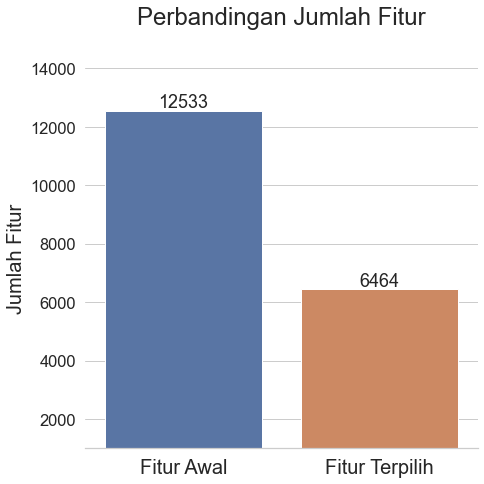

In [408]:
ax_y = [X.shape[1], np.count_nonzero(pop_pos[np.argmax(pop_acc)])]
ax_x = ['Fitur Awal', 'Fitur Terpilih']
plt.figure(figsize=(7,7))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
p = sns.barplot(x=ax_x, y=ax_y)
sns.despine(left=True)
p.set_title('Perbandingan Jumlah Fitur', fontsize=24, y=1.1)
p.set_ylabel("Jumlah Fitur", fontsize = 20)
p.set_xticklabels(ax_x, fontsize = 20)
p.set_ylim(1000, 14000)
sns.set(font_scale=1.3)
show_values(p, fmt='{:.0f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Jumlah Fitur.png')

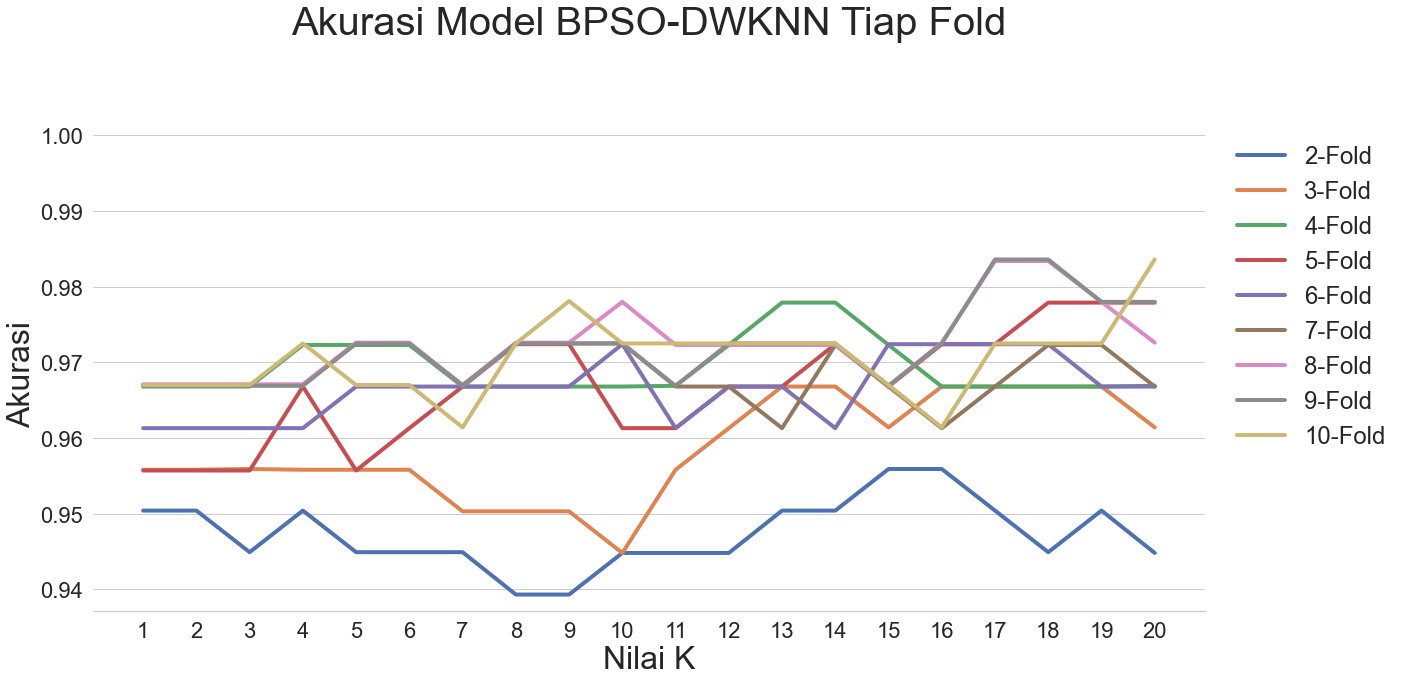

In [409]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_acc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Akurasi', fontsize=32)
p.set_yticks([0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1])
p.set_title('Akurasi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Akurasi BPSO-DW Tiap Fold.png')

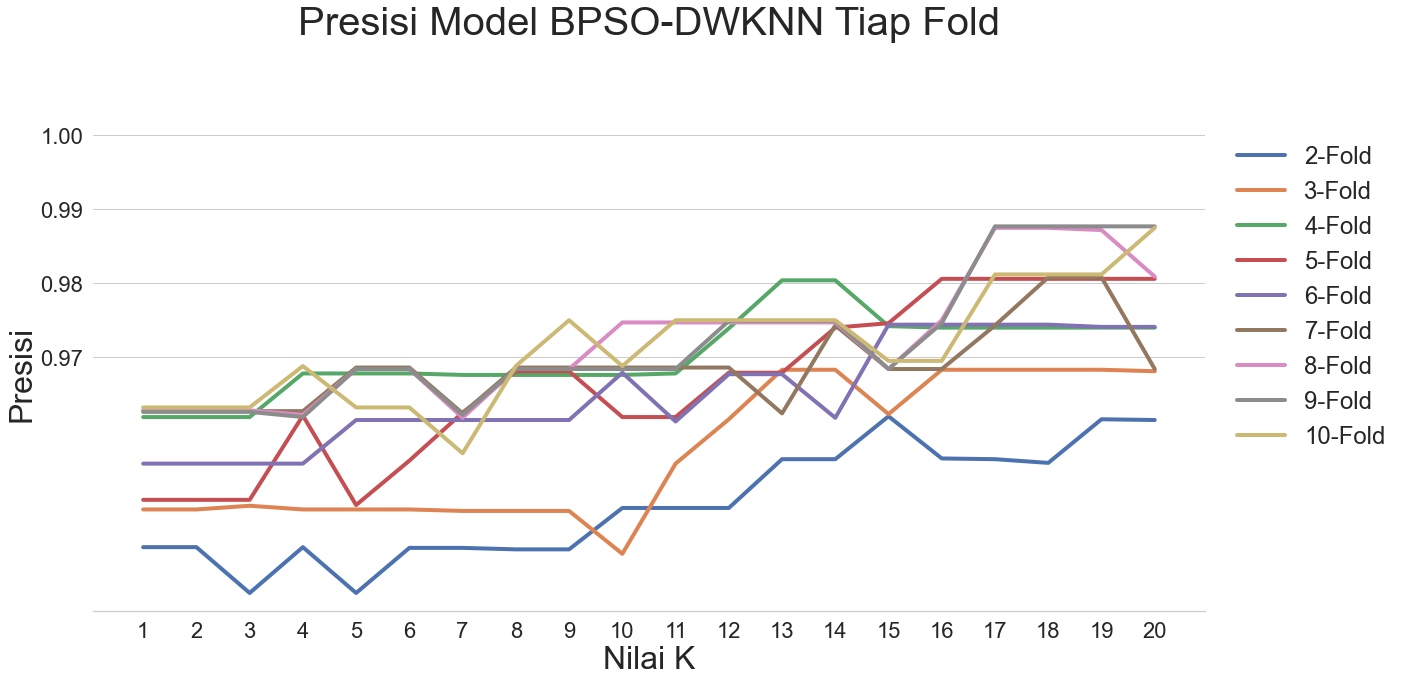

In [410]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_prc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Presisi', fontsize=32)
p.set_yticks([0.97, 0.98, 0.99, 1])
p.set_title('Presisi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Presisi BPSO-DW Tiap Fold.png')

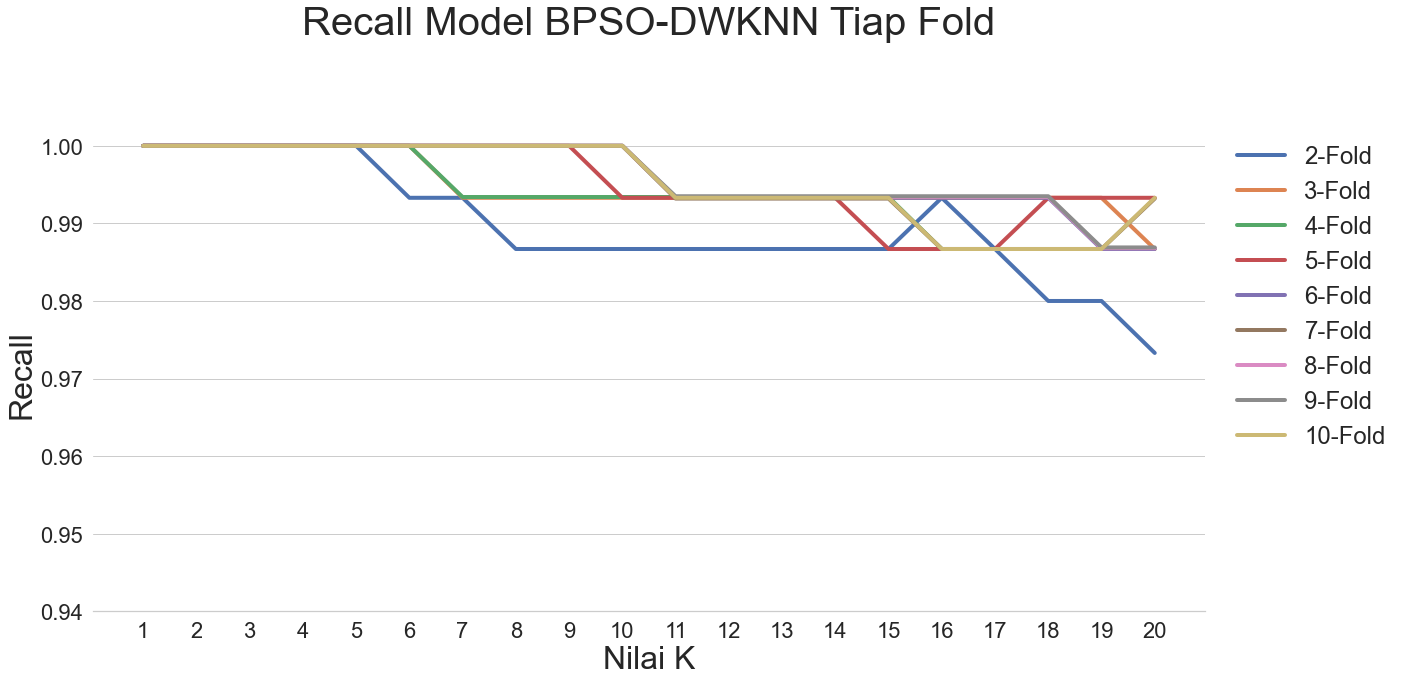

In [411]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_rcl[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Recall', fontsize=32)
p.set_yticks([0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1])
p.set_title('Recall Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Recall BPSO-DW Tiap Fold.png')

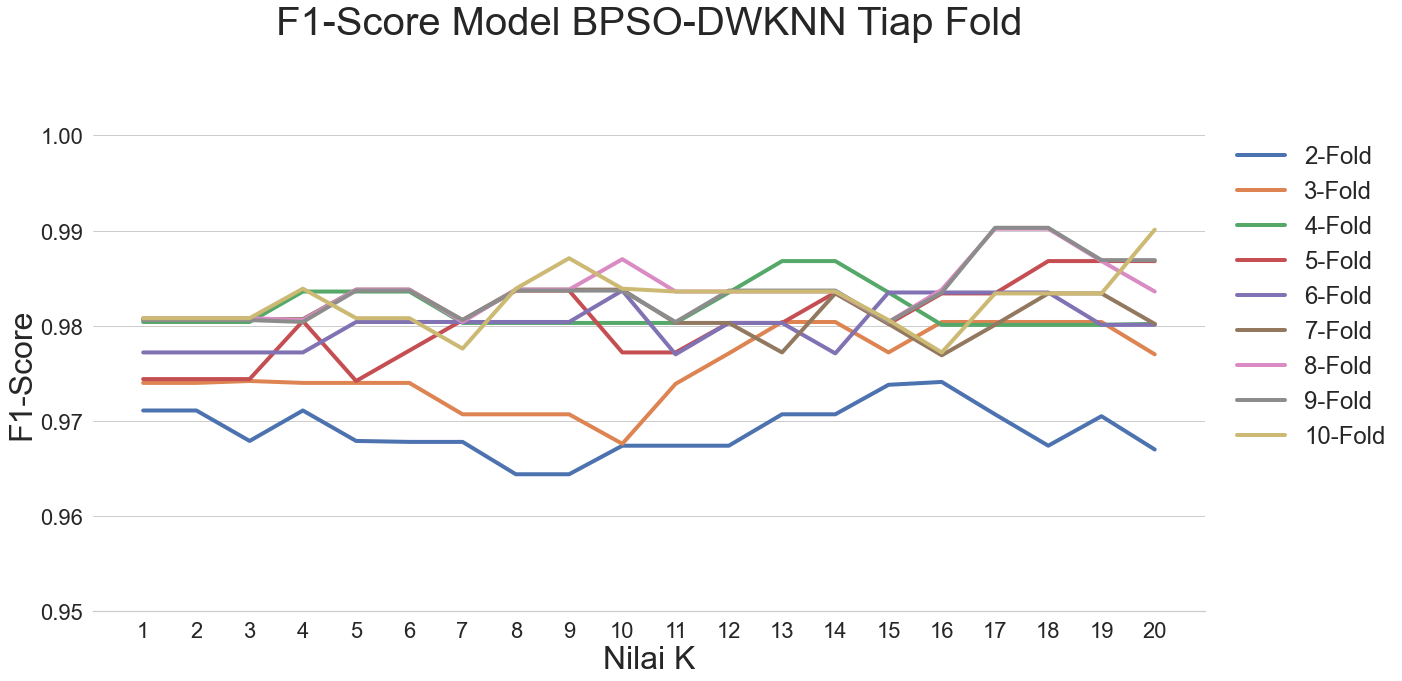

In [412]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_f1[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('F1-Score', fontsize=32)
p.set_yticks([0.95, 0.96, 0.97, 0.98, 0.99, 1])
p.set_title('F1-Score Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/F1-Score BPSO-DW Tiap Fold.png')

In [413]:
kfld_acc[7][16]

0.9836

Confusion matrix, without normalization


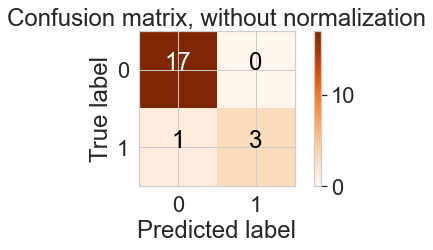

Confusion matrix, without normalization


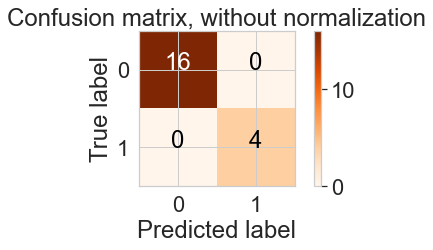

Confusion matrix, without normalization


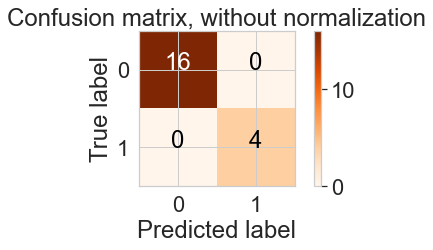

Confusion matrix, without normalization


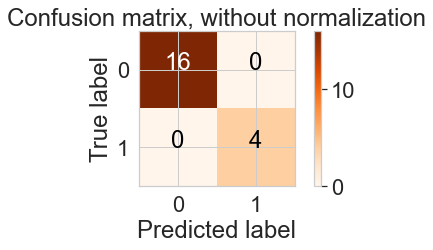

Confusion matrix, without normalization


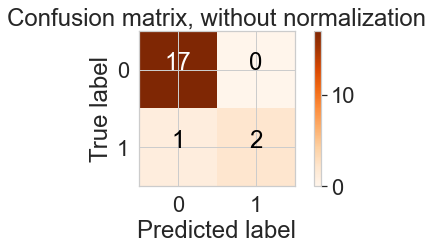

Confusion matrix, without normalization


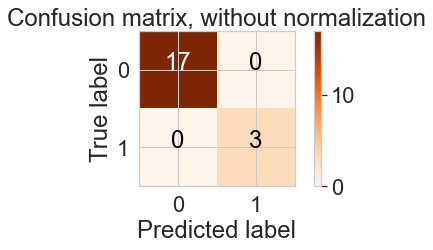

Confusion matrix, without normalization


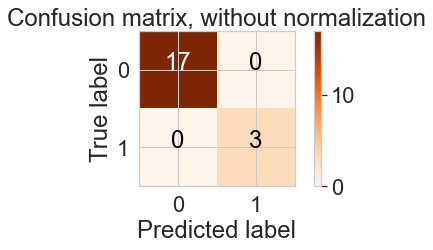

Confusion matrix, without normalization


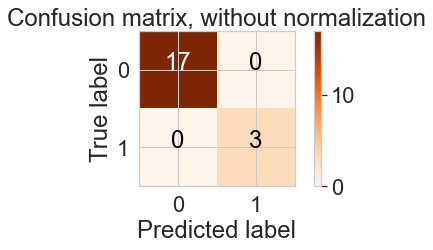

Confusion matrix, without normalization


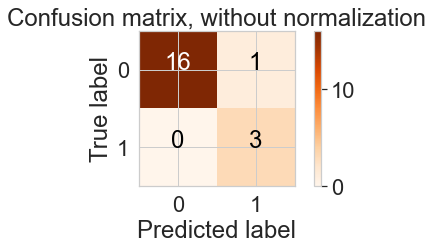

In [414]:
for i in range(9):
    plot_confusion_matrix(kfld_pred[7][16][i], kfld_act[7][16][i])

## DWKNN Plot

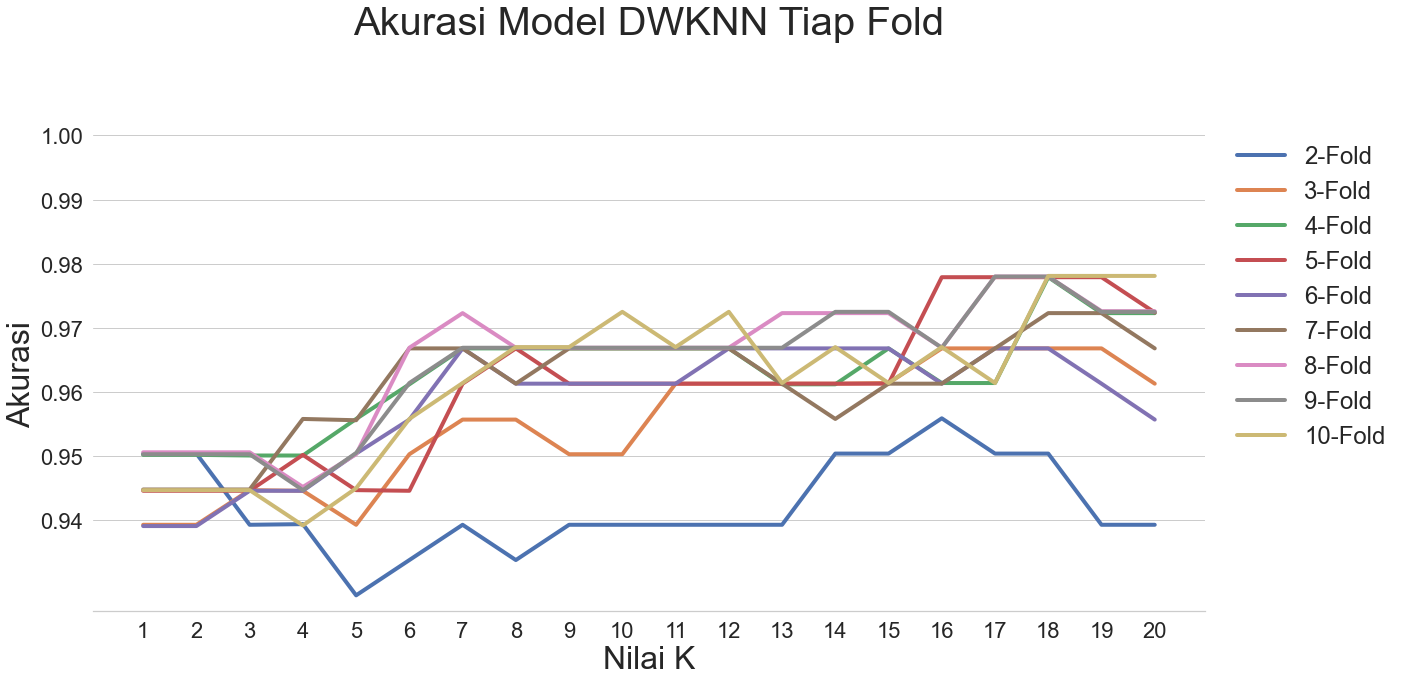

In [415]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_acc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Akurasi', fontsize=32)
p.set_yticks([0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1])
p.set_title('Akurasi Model DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Akurasi DW Tiap Fold.png')

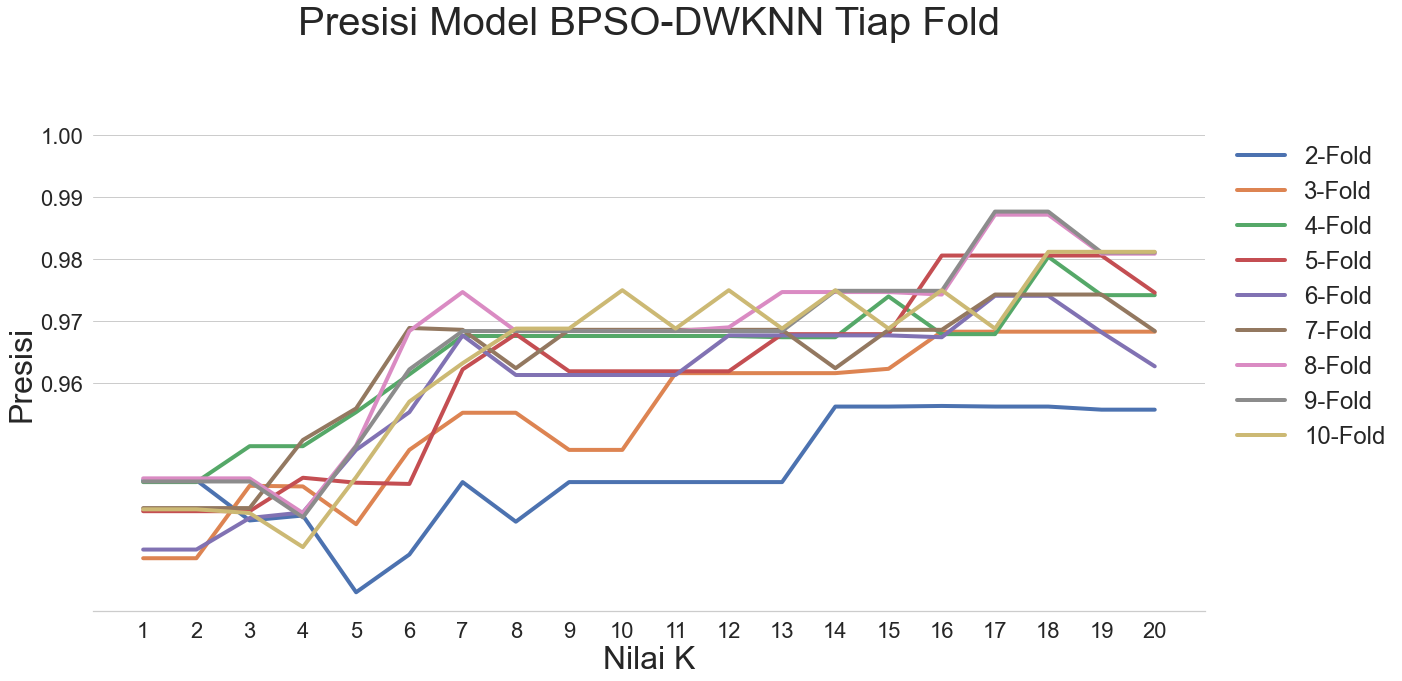

In [416]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_prc[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Presisi', fontsize=32)
p.set_yticks([0.96, 0.97, 0.98, 0.99, 1])
p.set_title('Presisi Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Presisi DW Tiap Fold.png')

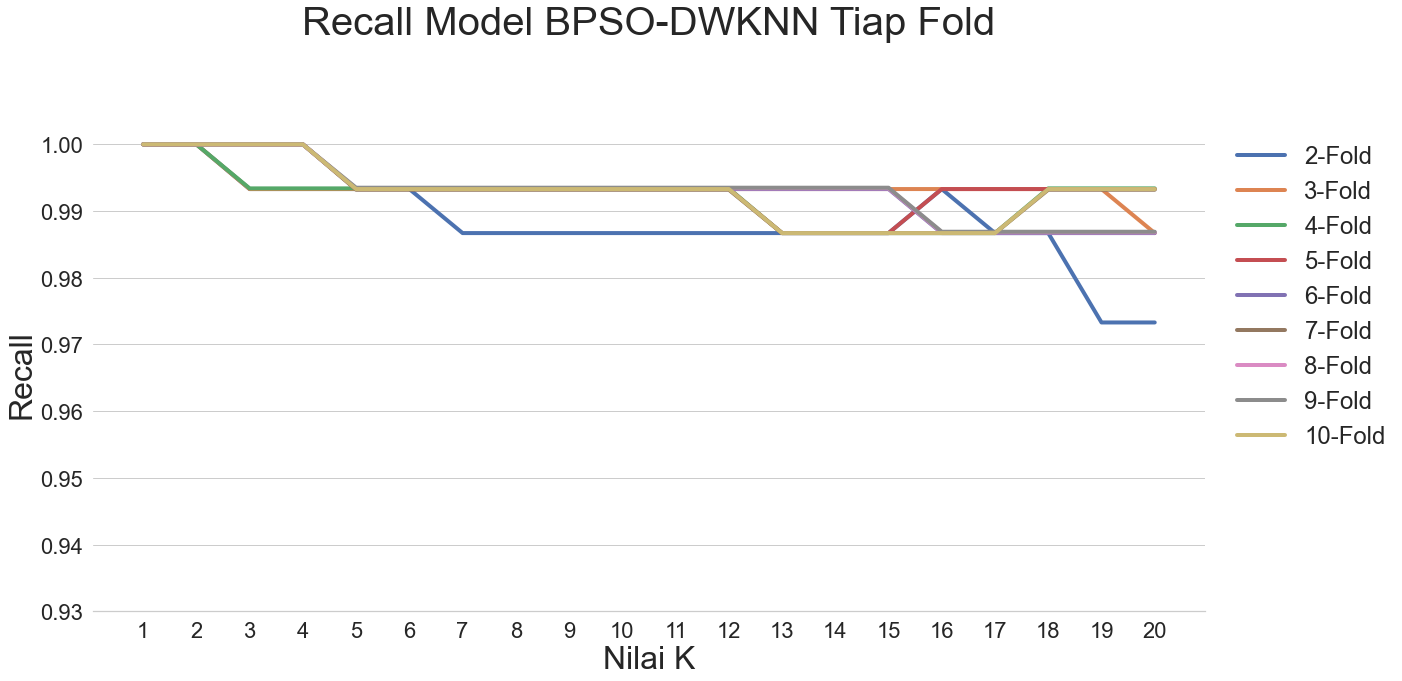

In [417]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_rcl[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('Recall', fontsize=32)
p.set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1])
p.set_title('Recall Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Recall DW Tiap Fold.png')

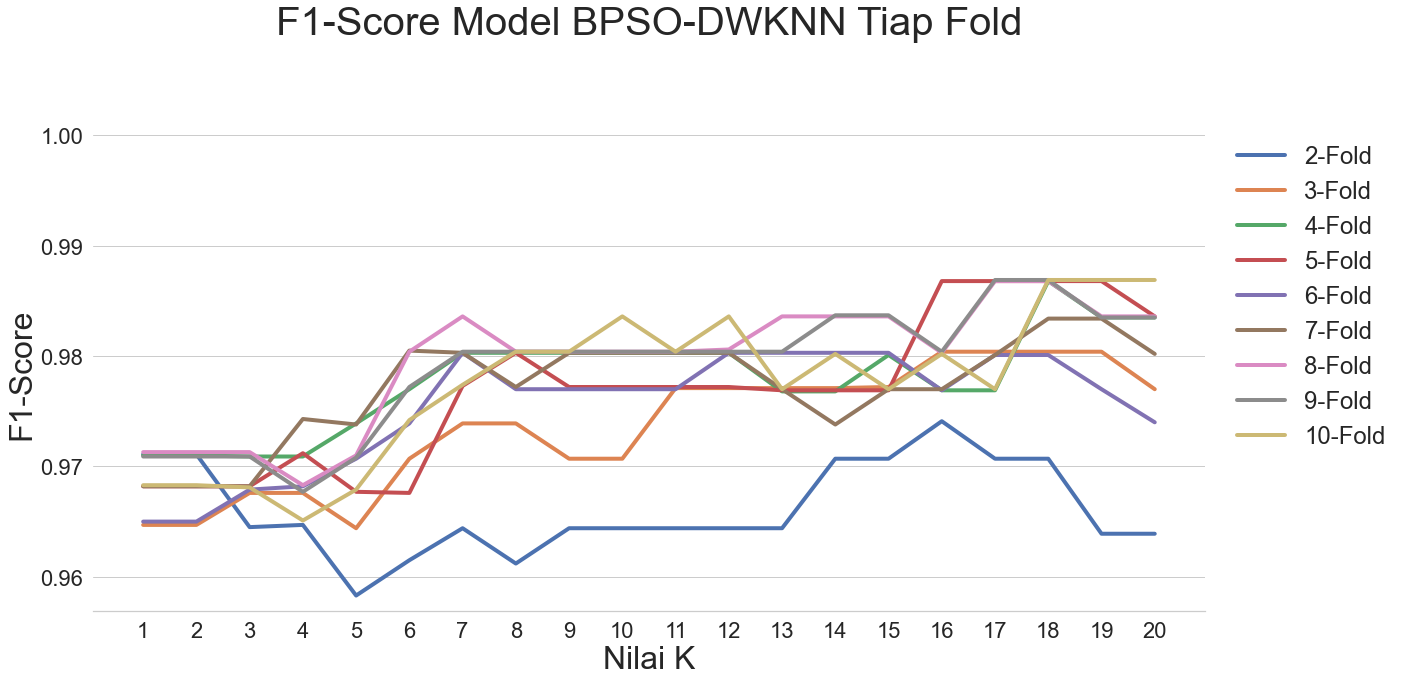

In [418]:
plt.figure(figsize=(20,10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2)
sns.set_style('whitegrid')
for i in range(9):
    p = sns.lineplot(range_k0, kfld_d_f1[i], label='{}-Fold'.format(i+2), linewidth=4)
p.xaxis.grid(False)
p.set_xlabel('Nilai K', fontsize=32)
p.set_xticks(range(1,21))
p.set_ylabel('F1-Score', fontsize=32)
p.set_yticks([0.96, 0.97, 0.98, 0.99, 1])
p.set_title('F1-Score Model BPSO-DWKNN Tiap Fold', fontsize=40, y=1.2)
sns.despine(left=True, bottom=False)
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/F1-Score DW Tiap Fold.png')

In [421]:
kfld_d_acc[8][17]

0.9781

Confusion matrix, without normalization


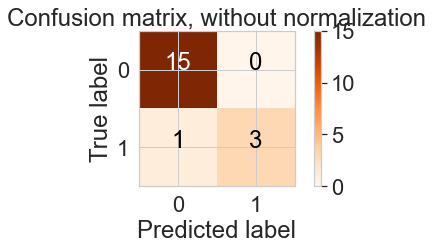

Confusion matrix, without normalization


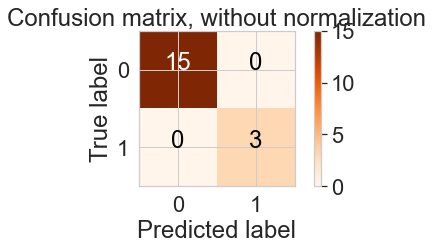

Confusion matrix, without normalization


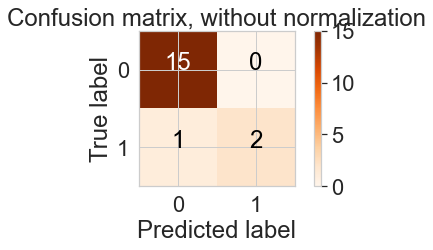

Confusion matrix, without normalization


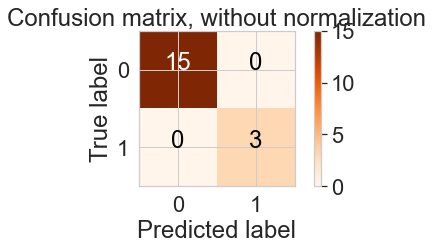

Confusion matrix, without normalization


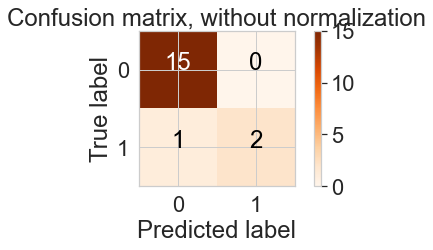

Confusion matrix, without normalization


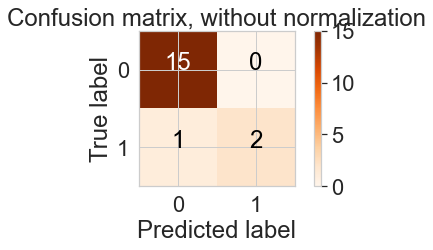

Confusion matrix, without normalization


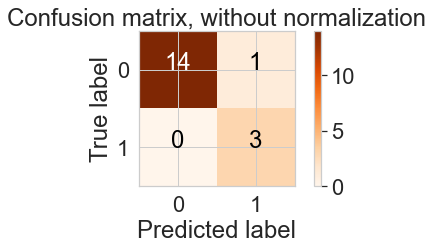

Confusion matrix, without normalization


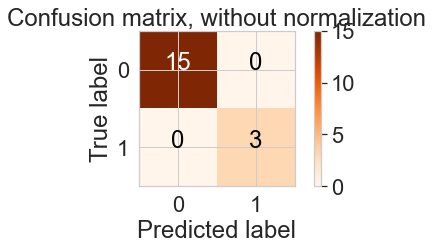

Confusion matrix, without normalization


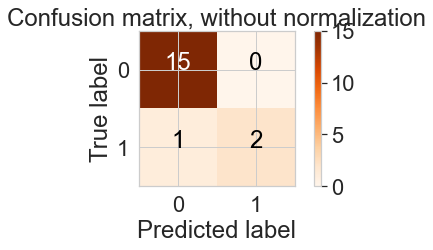

Confusion matrix, without normalization


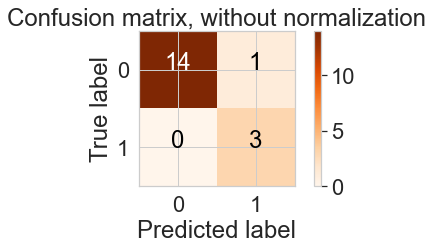

In [422]:
for i in range(10):
    plot_confusion_matrix(kfld_d_pred[8][16][i], kfld_d_act[8][17][i])

## BPSO-DWKNN vs DWKNN

In [423]:
fld = [2, 3, 4, 5, 6, 7, 8, 9, 10]
hsl01_df = pd.DataFrame({'Fold': fld,
              'Nilai K': val_k, 
              'Akurasi': max_akr,
              'Presisi': max_prc,
              'Recall': max_rcl,
              'F1-Score': max_f1,
              'Model': 'BPSO-DWKNN',
              })
hsl02_df = pd.DataFrame({'Fold': fld,
              'Nilai K': val_d_k, 
              'Akurasi': max_d_akr,
              'Presisi': max_d_prc,
              'Recall': max_d_rcl,
              'F1-Score': max_d_f1,
              'Model': 'DWKNN',
              })
hsl03_df = hsl01_df.append(hsl02_df)

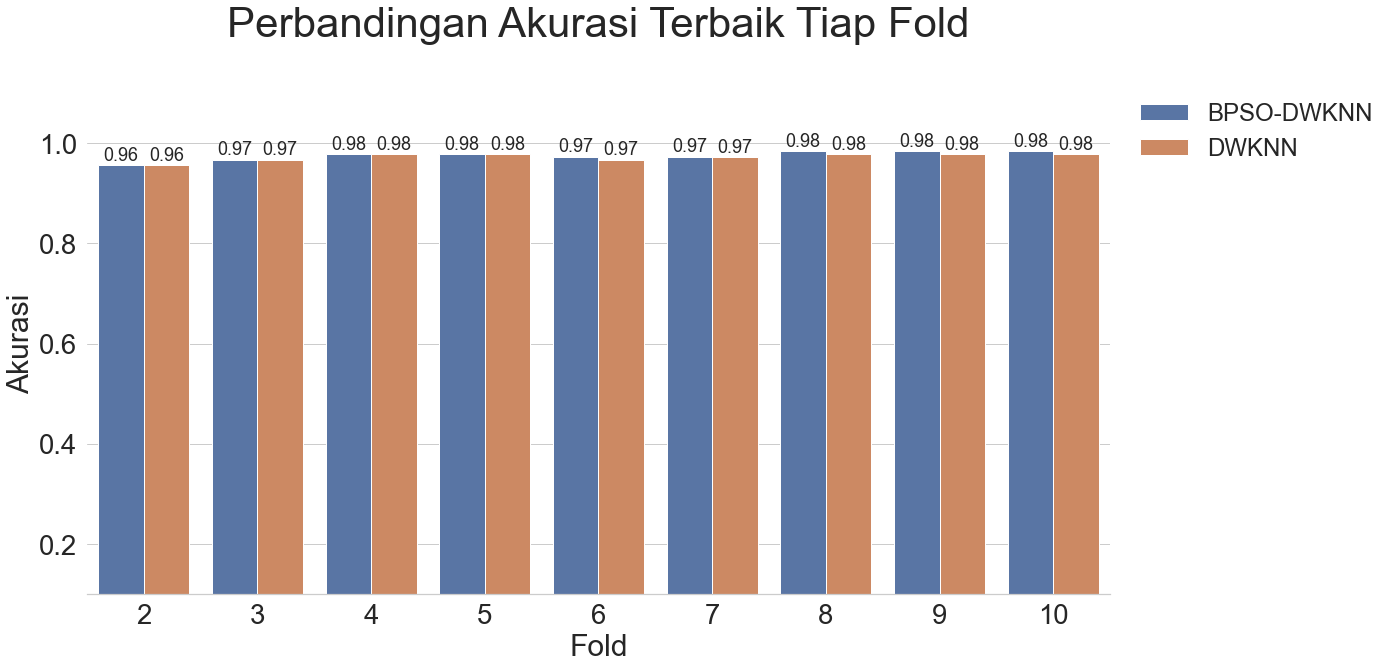

In [424]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Akurasi', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Perbandingan Akurasi Terbaik Tiap Fold.png')

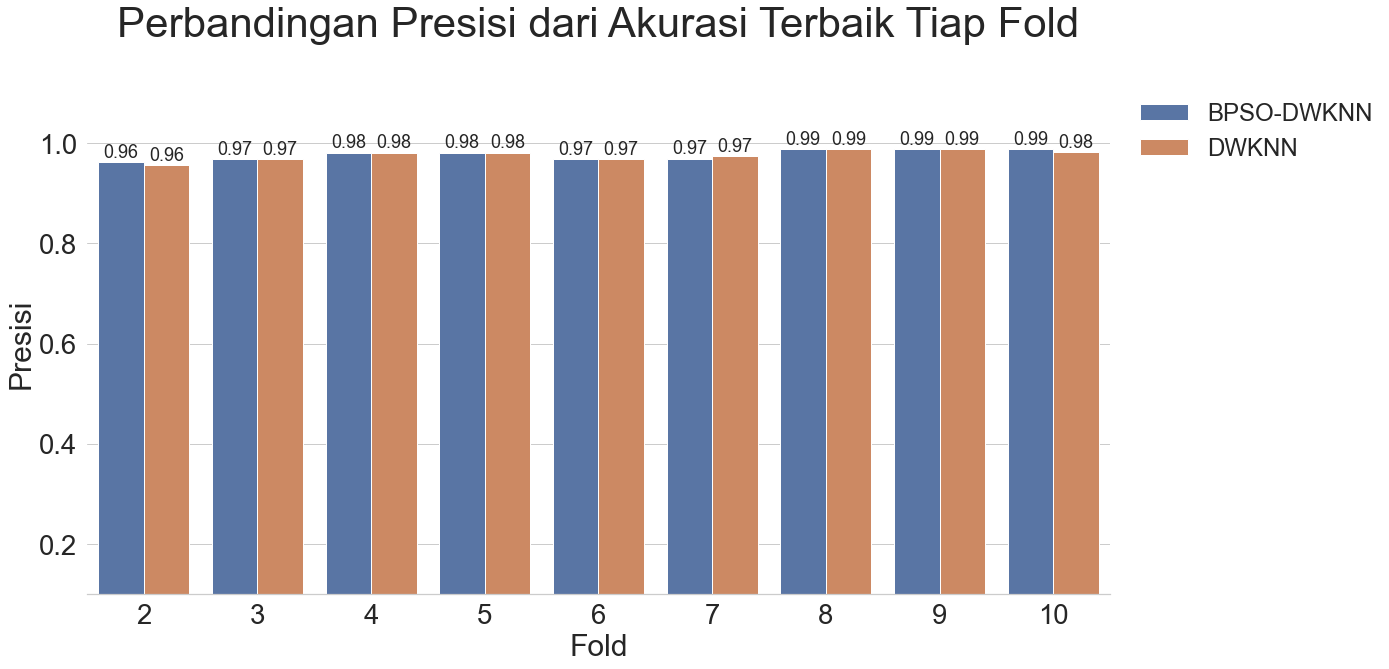

In [425]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Presisi', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Presisi dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Perbandingan Presisi dari Akurasi Terbaik Tiap Fold.png')

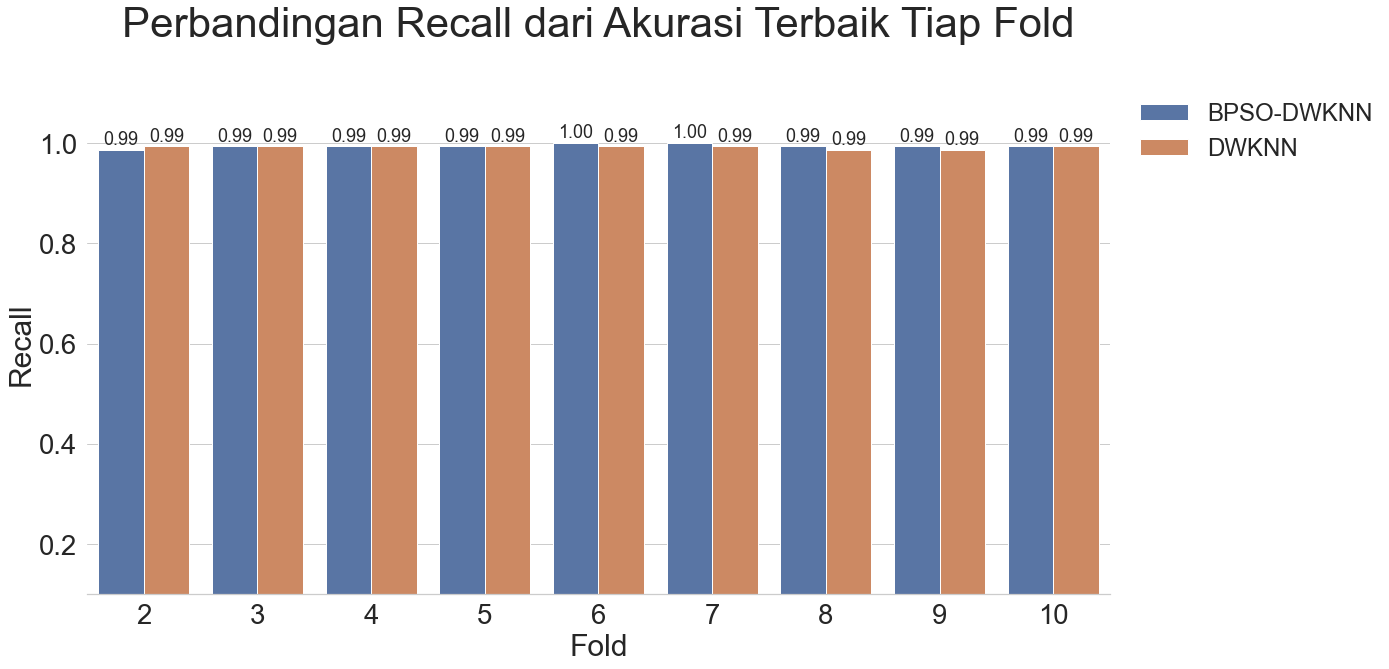

In [426]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='Recall', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan Recall dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Perbandingan Recall dari Akurasi Terbaik Tiap Fold.png')

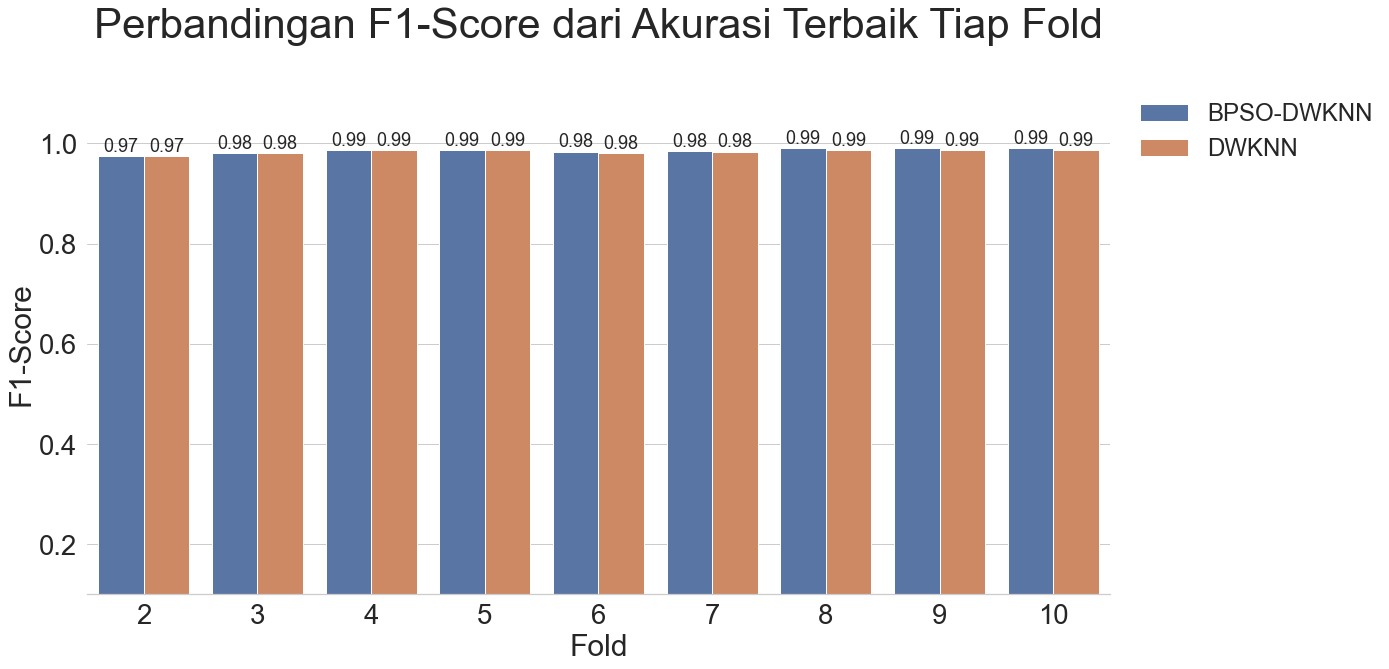

In [427]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
p = sns.barplot(x='Fold', y='F1-Score', data=hsl03_df, hue='Model')
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
p.set_title('Perbandingan F1-Score dari Akurasi Terbaik Tiap Fold', fontsize=42, y=1.1)
show_values(p, fmt='{:.2f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/Perbandingan F1-Score dari Akurasi Terbaik Tiap Fold.png')

In [428]:
max_all_df = pd.DataFrame({'Matriks':['Akurasi', 'Presisi', 'Recall', 'F1-Score', 'Akurasi', 'Presisi', 'Recall', 'F1-Score'],
                        'Nilai':[np.max(bpdw_df.AkurasiTest.values), 
                                 bpdw_df.Presisi[np.argmax(bpdw_df.AkurasiTest.values)],                        
                                 bpdw_df.Recall[np.argmax(bpdw_df.AkurasiTest.values)], 
                                 bpdw_df.F1_Score[np.argmax(bpdw_df.AkurasiTest.values)], 
                                 np.max(dw_df.AkurasiTest.values), 
                                 dw_df.Presisi[np.argmax(dw_df.AkurasiTest.values)], 
                                 dw_df.Recall[np.argmax(dw_df.AkurasiTest.values)],
                                 dw_df.F1_Score[np.argmax(dw_df.AkurasiTest.values)]],
                        'Model':['BPSO-DWKNN', 'BPSO-DWKNN', 'BPSO-DWKNN', 'BPSO-DWKNN', 'DWKNN', 'DWKNN', 'DWKNN', 'DWKNN'],
                      })

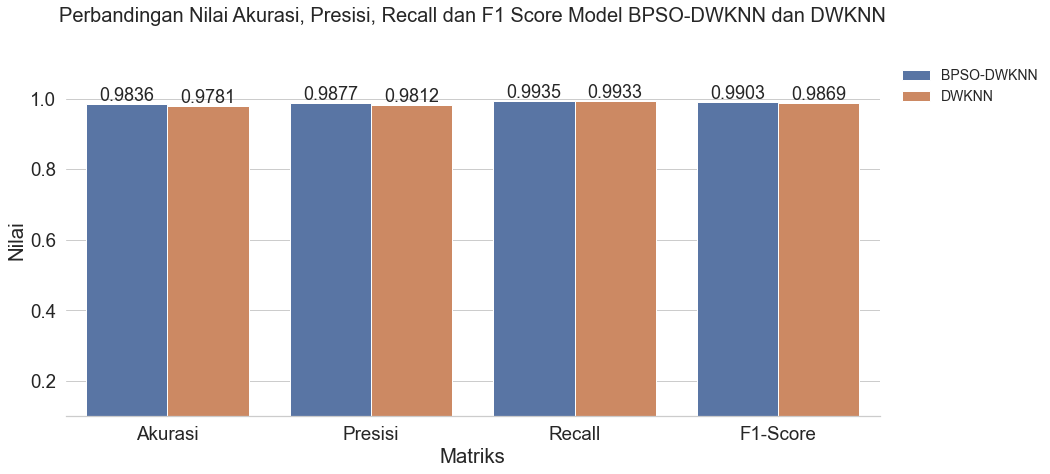

In [429]:
plt.figure(figsize=(15, 7))
plt.rcParams['figure.autolayout'] = True
sns.set(font_scale=1.7)
sns.set_style('whitegrid')
p = sns.barplot(x='Matriks', y='Nilai', hue='Model', data=max_all_df)
sns.despine(left=True)
p.set(ylim=(0.1, 1.1))
p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14, frameon=False)
p.set_title('Perbandingan Nilai Akurasi, Presisi, Recall dan F1 Score Model BPSO-DWKNN dan DWKNN', fontsize=20, y=1.1)
show_values(p, fmt='{:.4f}')
p_fig = p.get_figure()
p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/ConfusionMatrix BPSO-DW Vs DW.png')

## DataFrame to Excel

In [430]:
result_df = pd.DataFrame({'Model': ['BPSO-DWKNN', 'DWKNN'],
                      'Fold': [bpdw_df.Fold[np.argmax(bpdw_df.AkurasiTest)], dw_df.Fold[np.argmax(dw_df.AkurasiTest)]],
                      'Nilai K': [bpdw_df.Nilai_K[np.argmax(bpdw_df.AkurasiTest)], dw_df.Nilai_K[np.argmax(dw_df.AkurasiTest)]],
                      'Akurasi Train': [np.max(bpdw_df.AkurasiTrain.values), np.max(dw_df.AkurasiTrain.values)],
                      'Akurasi Test': [np.max(bpdw_df.AkurasiTest.values), np.max(dw_df.AkurasiTest.values)],
                      'Presisi': [bpdw_df.Presisi[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.Presisi[np.argmax(dw_df.AkurasiTest.values)]],
                      'Recall': [bpdw_df.Recall[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.Recall[np.argmax(dw_df.AkurasiTest.values)]],
                      'F1-Score': [bpdw_df.F1_Score[np.argmax(bpdw_df.AkurasiTest.values)], dw_df.F1_Score[np.argmax(dw_df.AkurasiTest.values)]],
                      'Jumlah Fitur': [np.count_nonzero(pop_pos[np.argmax(pop_acc)]), X.shape[1]],
                      })

C:\Anaconda\envs\jcopml\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


In [431]:
result_df

Model  Fold  Nilai K  Akurasi Train  Akurasi Test  Presisi  Recall  \
0  BPSO-DWKNN     9       17            1.0        0.9836   0.9877  0.9935   
1       DWKNN    10       18            1.0        0.9781   0.9812  0.9933   

   F1-Score  Jumlah Fitur  
0    0.9903          6464  
1    0.9869         12533

In [467]:
fold_fs_df.name = "Percobaan Fold Pada Seleksi Fitur"
w0_df.name = "W = 0.9"
w1_df.name = "W = 0.1"
pop_df.name = "Percobaan Populasi"
result_df.name = "Hasil Akurasi"
bpdw_df.name = "Akurasi Terbaik BPSO-DWKNN tiap Fold"
dw_df.name = "Akurasi Terbaik DWKNN tiap Fold"

acc_bpdw_k_df.name = "Akurasi Per K Tiap Fold"
prc_bpdw_k_df.name = "Presisi Per K Tiap Fold"
rcl_bpdw_k_df.name = "Recall Per K Tiap Fold"
f1_bpdw_k_df.name = "F1-Score Per K Tiap Fold"

acc_d_bpdw_k_df.name = "Akurasi Per K Tiap Fold"
prc_d_bpdw_k_df.name = "Presisi Per K Tiap Fold"
rcl_d_bpdw_k_df.name = "Recall Per K Tiap Fold"
f1_d_bpdw_k_df.name = "F1-Score Per K Tiap Fold"

writer = pd.ExcelWriter('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung.xlsx',engine='xlsxwriter')
workbook=writer.book

# Formating
merge_format = workbook.add_format({
    'bold': 1,
    'border': None,
    'align': 'center',
    'valign': 'vcenter',
    'fg_color': '#fc8f30',
    'font_color': 'white'})

cell_format = workbook.add_format({
    'bg_color': '#ffdea1'})

border_fmt = workbook.add_format({
    'bottom':3, 
    'top':3, 
    'left':3, 
    'right':3})


# Excel Fold
worksheet=workbook.add_worksheet('Fold')
writer.sheets['Fold'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(fold_fs_df)+1, len(fold_fs_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:G1', fold_fs_df.name, merge_format)
# to_xlsx
fold_fs_df.to_excel(writer,sheet_name='Fold',startrow=1 , startcol=0, index=None)

#Excel Parameter PSO
worksheet=workbook.add_worksheet('BPSOPar')
writer.sheets['BPSOPar'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(w0_df)+1, len(w0_df.columns)), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 5), {'type': 'no_errors', 'format': cell_format})
worksheet.conditional_format(xlsxwriter.utility.xl_range(2, 0, 6, 0), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:F1', w0_df.name, merge_format)
# to_xlsx
w0_df.to_excel(writer,sheet_name='BPSOPar',startrow=1 , startcol=0)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(10, 0, 15, 5), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(10, 0, 10, 5), {'type': 'no_errors', 'format': cell_format})
worksheet.conditional_format(xlsxwriter.utility.xl_range(11, 0, 15, 0), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A10:F10', w1_df.name, merge_format)
# to_xlsx
w1_df.to_excel(writer,sheet_name='BPSOPar',startrow=w0_df.shape[0] + 5, startcol=0)
# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(19, 0, 23, 6), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(19, 0, 19, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A19:G19', pop_df.name, merge_format)
# to_xlsx
pop_df.to_excel(writer,sheet_name='BPSOPar',startrow=w0_df.shape[0] + w1_df.shape[0] + 9, startcol=0, index=None)

# Excel Tabel Akurasi Terbaik BPSO-DW Tiap Fold
worksheet=workbook.add_worksheet('BPSO-DWKNN')
writer.sheets['BPSO-DWKNN'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(bpdw_df)+1, len(bpdw_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 7), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:H1', bpdw_df.name, merge_format)
# to_xlsx
bpdw_df.to_excel(writer,sheet_name='BPSO-DWKNN',startrow=1 , startcol=0, index=None)

# Excel Tabel Akurasi Terbaik DW Tiap Fold
worksheet=workbook.add_worksheet('DWKNN')
writer.sheets['DWKNN'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(dw_df)+1, len(dw_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 6), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:G1', dw_df.name, merge_format)
# to_xlsx
dw_df.to_excel(writer,sheet_name='DWKNN',startrow=1 , startcol=0, index=None)

#Excel Hasil Akhir
worksheet=workbook.add_worksheet('Hasil Akurasi')
writer.sheets['Hasil Akurasi'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(result_df)+1, len(result_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 8), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:I1', result_df.name, merge_format)
# to xlsx
result_df.to_excel(writer,sheet_name='Hasil Akurasi',startrow=1 , startcol=0, index=None)

#Excel Acc, prc, rcl, f1 BPSO DW perFold
worksheet=workbook.add_worksheet('BPSO-DW Acc, Prc, Rcl, F1')
writer.sheets['BPSO-DW Acc, Prc, Rcl, F1'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(acc_bpdw_k_df)+1, len(acc_bpdw_k_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:J1', acc_bpdw_k_df.name, merge_format)
# to xlsx
acc_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1',startrow=1 , startcol=0, index=None)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 45, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 25, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A25:J25', prc_bpdw_k_df.name, merge_format)
# to_xlsx
prc_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5, startcol=0, index=None)

# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 69, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 49, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A49:J49', rcl_bpdw_k_df.name, merge_format)
# to_xlsx
rcl_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5 + prc_bpdw_k_df.shape[0] + 4, startcol=0, index=None)
# Styling Tabel 4
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 93, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 73, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A73:J73', f1_bpdw_k_df.name, merge_format)
# to_xlsx
f1_bpdw_k_df.to_excel(writer,sheet_name='BPSO-DW Acc, Prc, Rcl, F1', startrow=acc_bpdw_k_df.shape[0] + 5 + prc_bpdw_k_df.shape[0] + 5 + rcl_bpdw_k_df.shape[0] + 3, startcol=0, index=None)

#Excel Acc, prc, rcl, f1 DW perFold
worksheet=workbook.add_worksheet('DW Acc, Prc, Rcl, F1')
writer.sheets['DW Acc, Prc, Rcl, F1'] = worksheet
# Styling Tabel 1
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, len(acc_d_bpdw_k_df)+1, len(acc_d_bpdw_k_df.columns)-1), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(1, 0, 1, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A1:J1', acc_d_bpdw_k_df.name, merge_format)
# to xlsx
acc_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1',startrow=1 , startcol=0, index=None)
# Styling Tabel 2
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 45, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(25, 0, 25, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A25:J25', prc_d_bpdw_k_df.name, merge_format)
# to_xlsx
prc_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5, startcol=0, index=None)

# Styling Tabel 3
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 69, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(49, 0, 49, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A49:J49', rcl_d_bpdw_k_df.name, merge_format)
# to_xlsx
rcl_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5 + prc_d_bpdw_k_df.shape[0] + 4, startcol=0, index=None)
# Styling Tabel 4
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 93, 9), {'type': 'no_errors', 'format': border_fmt})
worksheet.conditional_format(xlsxwriter.utility.xl_range(73, 0, 73, 9), {'type': 'no_errors', 'format': cell_format})
worksheet.merge_range('A73:J73', f1_d_bpdw_k_df.name, merge_format)
# to_xlsx
f1_d_bpdw_k_df.to_excel(writer,sheet_name='DW Acc, Prc, Rcl, F1', startrow=acc_d_bpdw_k_df.shape[0] + 5 + prc_d_bpdw_k_df.shape[0] + 5 + rcl_d_bpdw_k_df.shape[0] + 3, startcol=0, index=None)

writer.save()

## Plot Per Fold

### BPSO-DWKNN

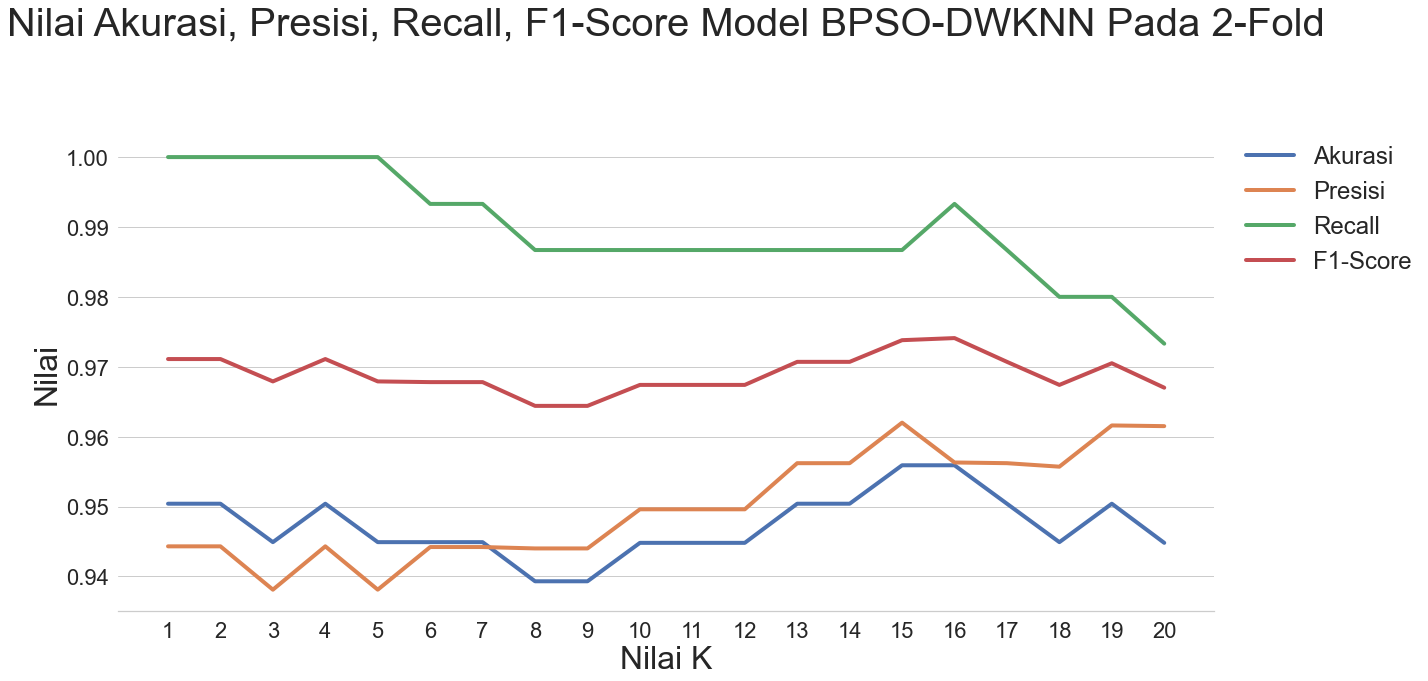

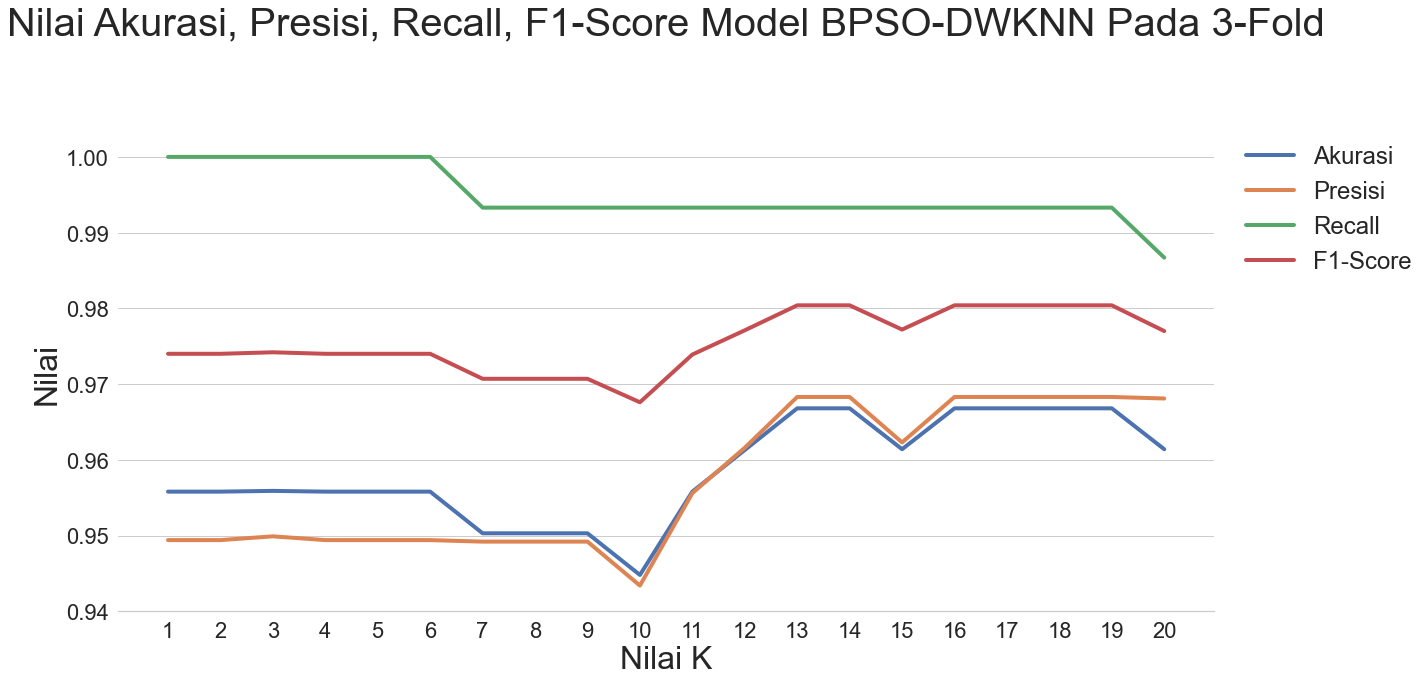

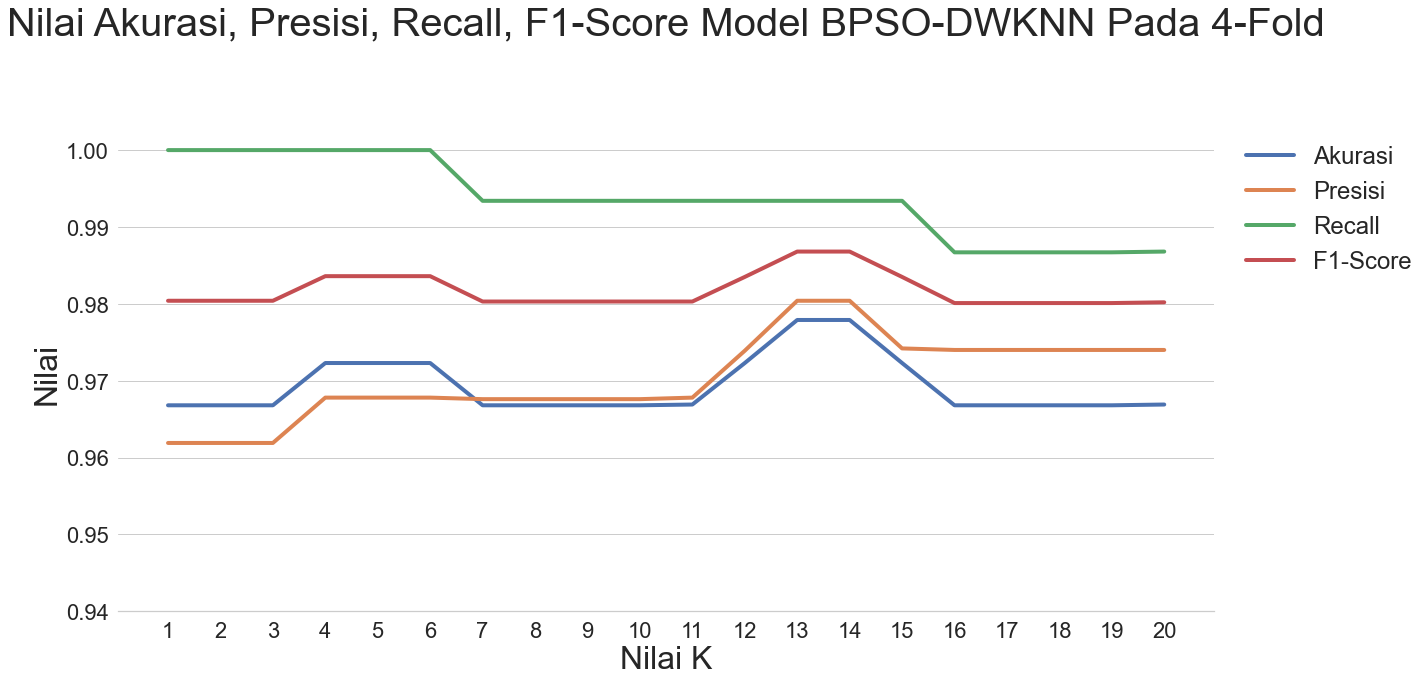

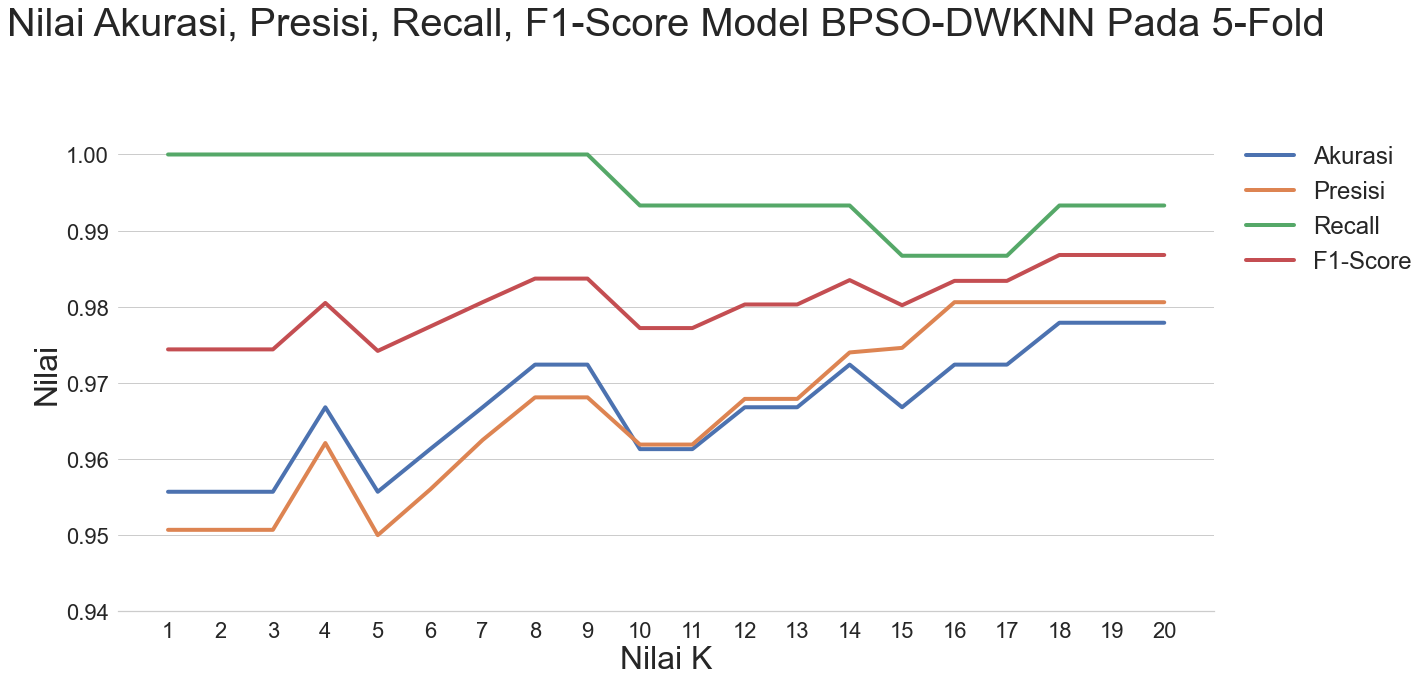

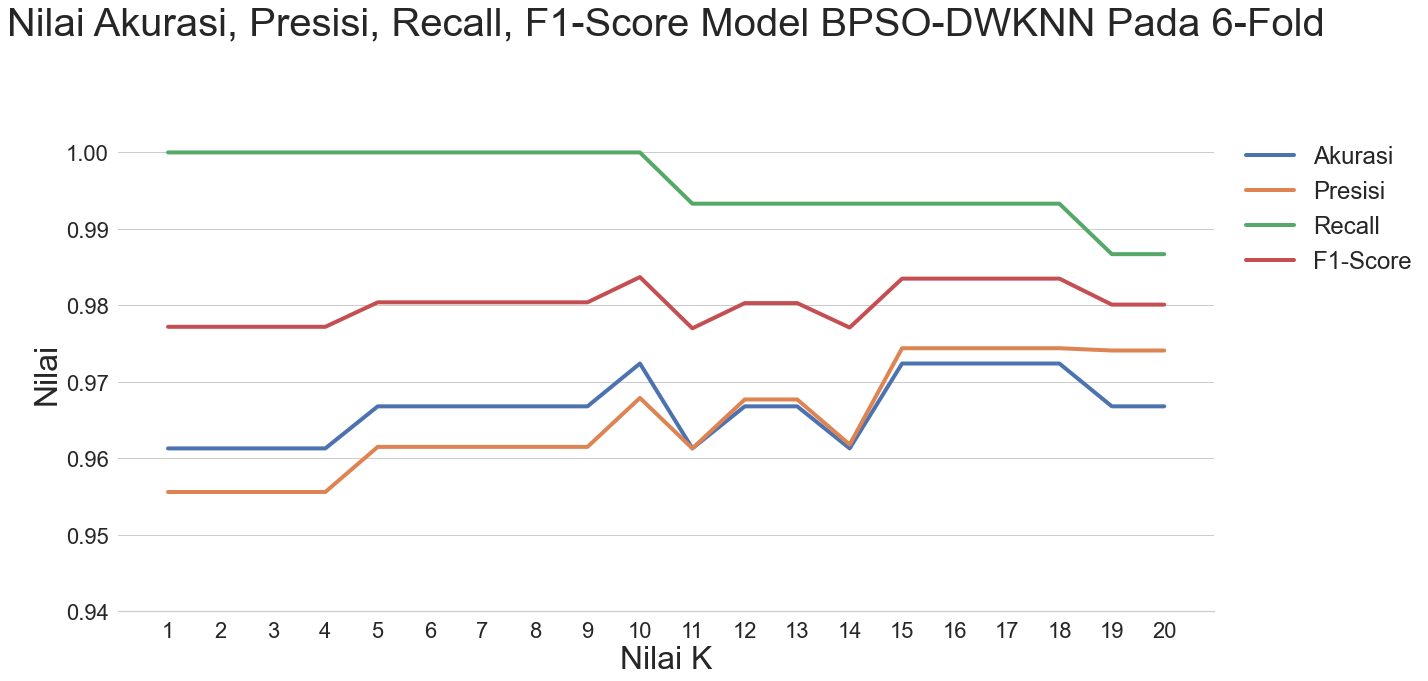

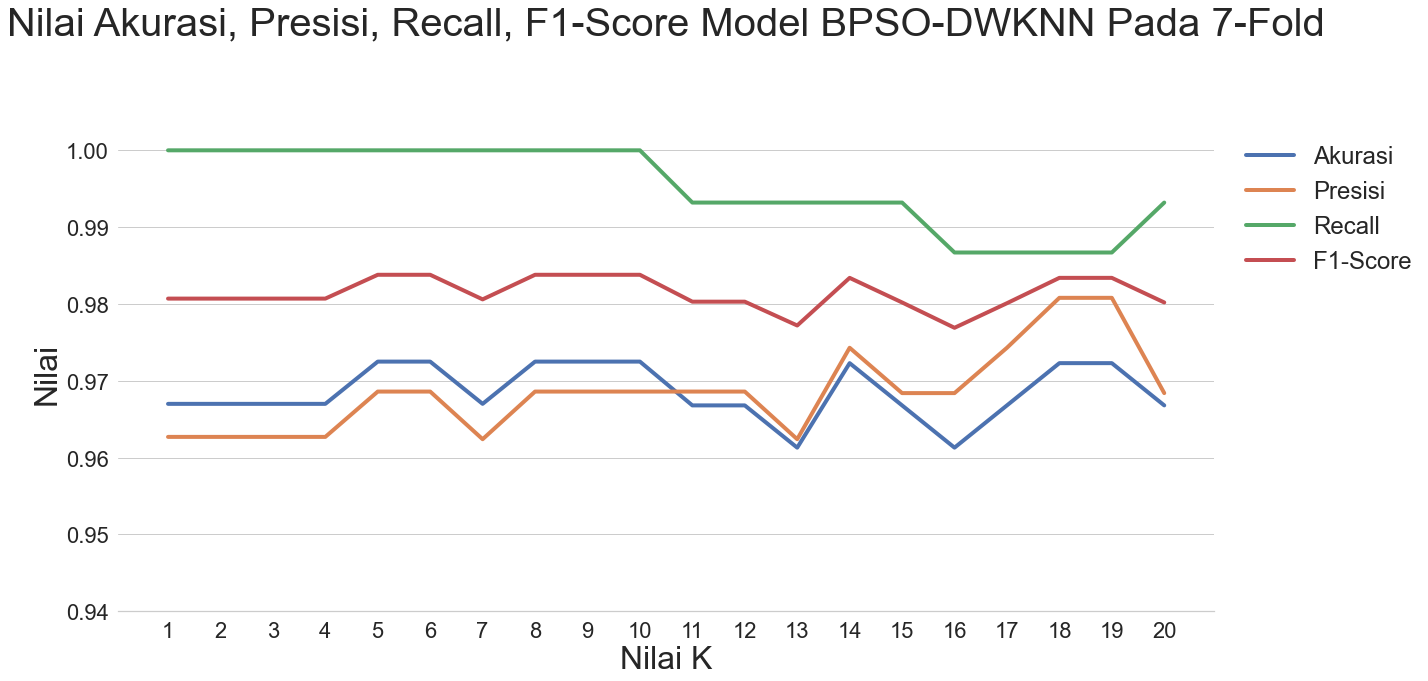

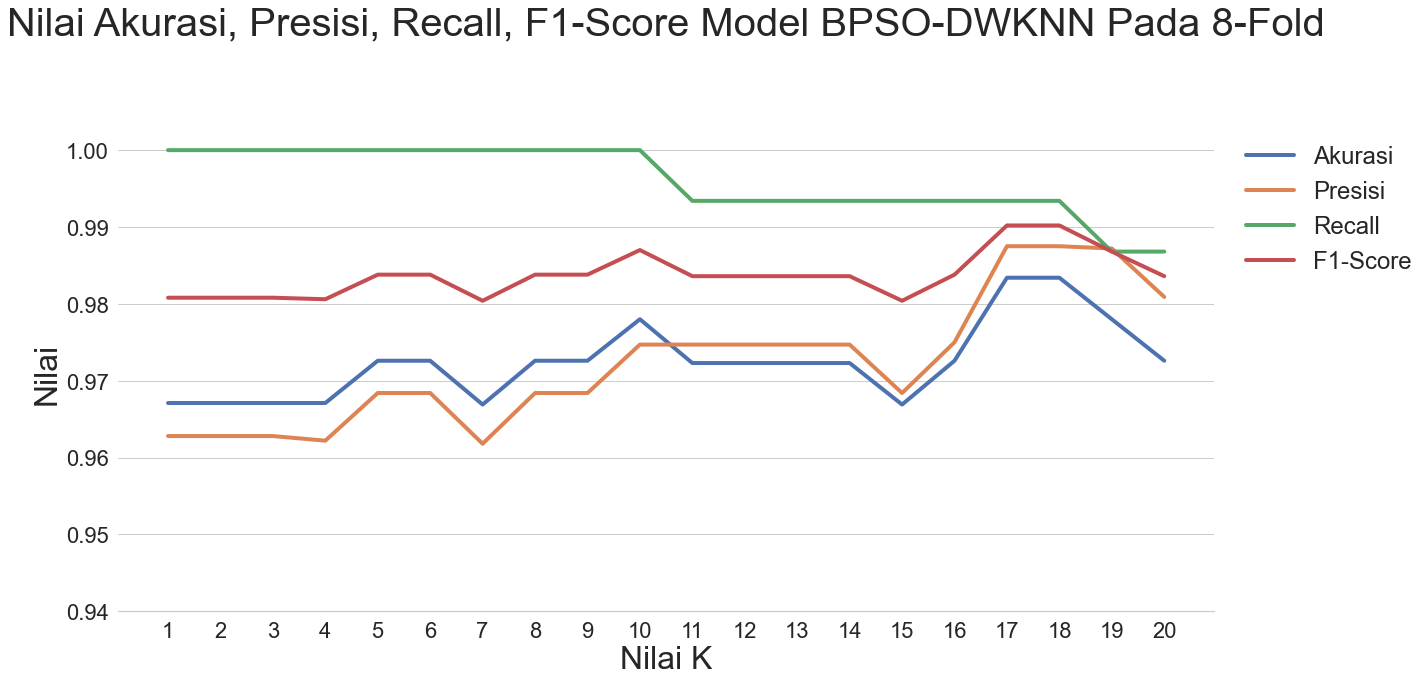

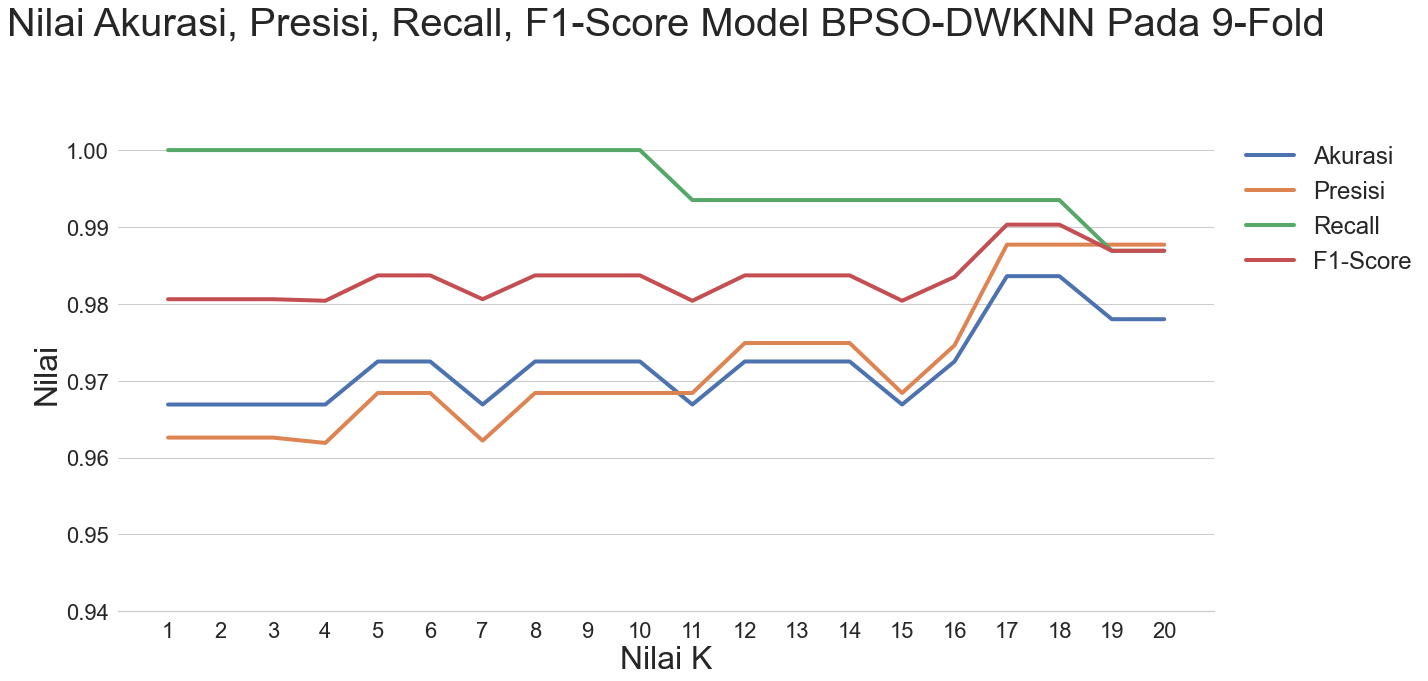

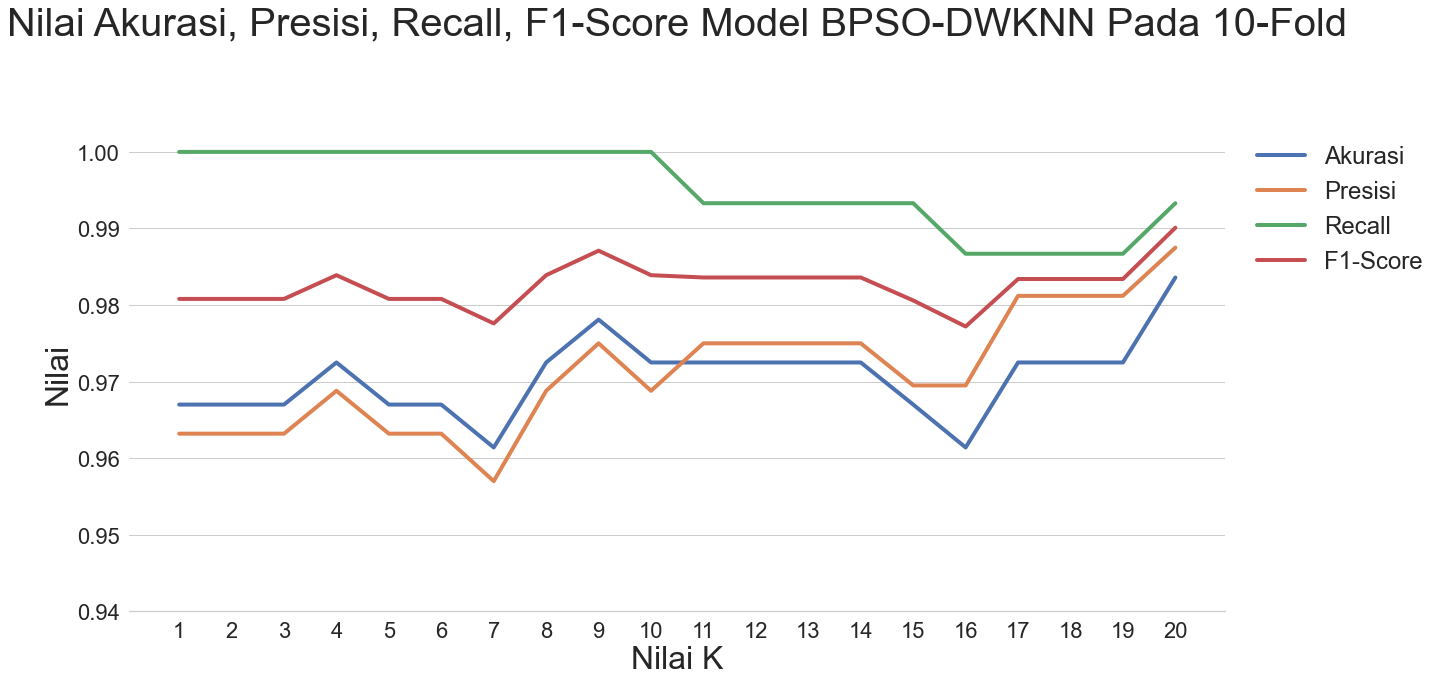

In [433]:
for i in range(9):
    plt.figure(figsize=(20,10))
    plt.rcParams['figure.autolayout'] = True
    sns.set(font_scale=2)
    sns.set_style('whitegrid')
    p = sns.lineplot(range_k0, kfld_acc[i], label='Akurasi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_prc[i], label='Presisi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_rcl[i], label='Recall', linewidth=4)
    p = sns.lineplot(range_k0, kfld_f1[i], label='F1-Score', linewidth=4)
    p.set_title('Nilai Akurasi, Presisi, Recall, F1-Score Model BPSO-DWKNN Pada {}-Fold'.format(i+2), fontsize=40, y=1.2)
    p.xaxis.grid(False)
    p.set_xlabel('Nilai K', fontsize=32)
    p.set_xticks(range(1,21))
    p.set_ylabel('Nilai', fontsize=32)
    p.set_yticks([0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1])
    sns.despine(left=True, bottom=False)
    p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
    p_fig = p.get_figure()
    p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/BPSO-DW Per Fold/BPSO-DW {}-Fold.png'.format(i+2))

### DWKNN

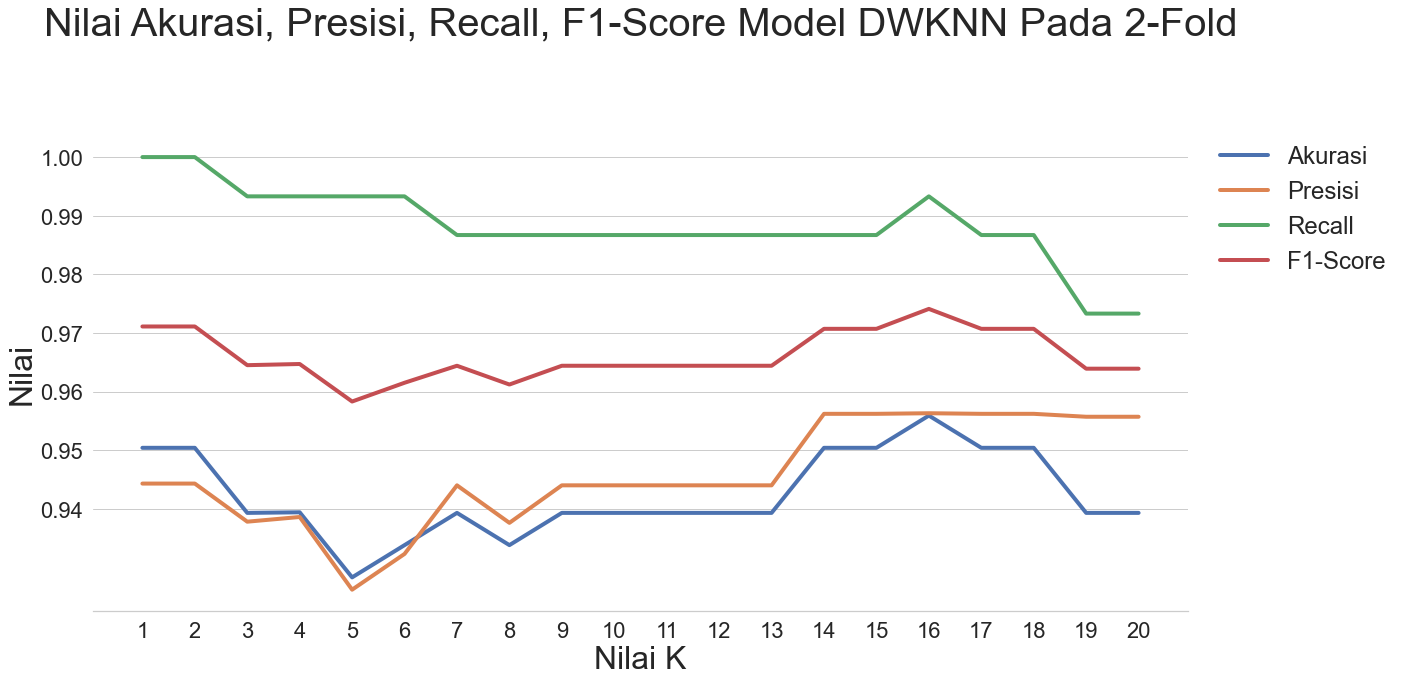

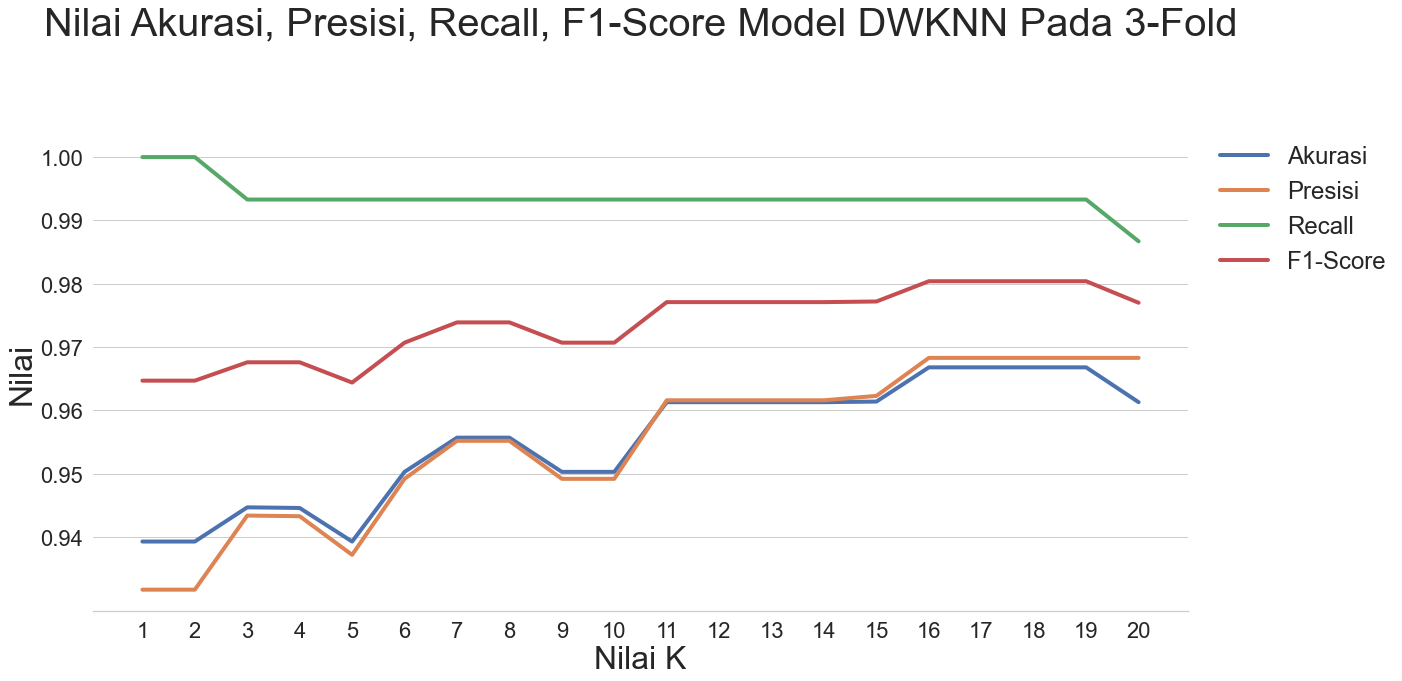

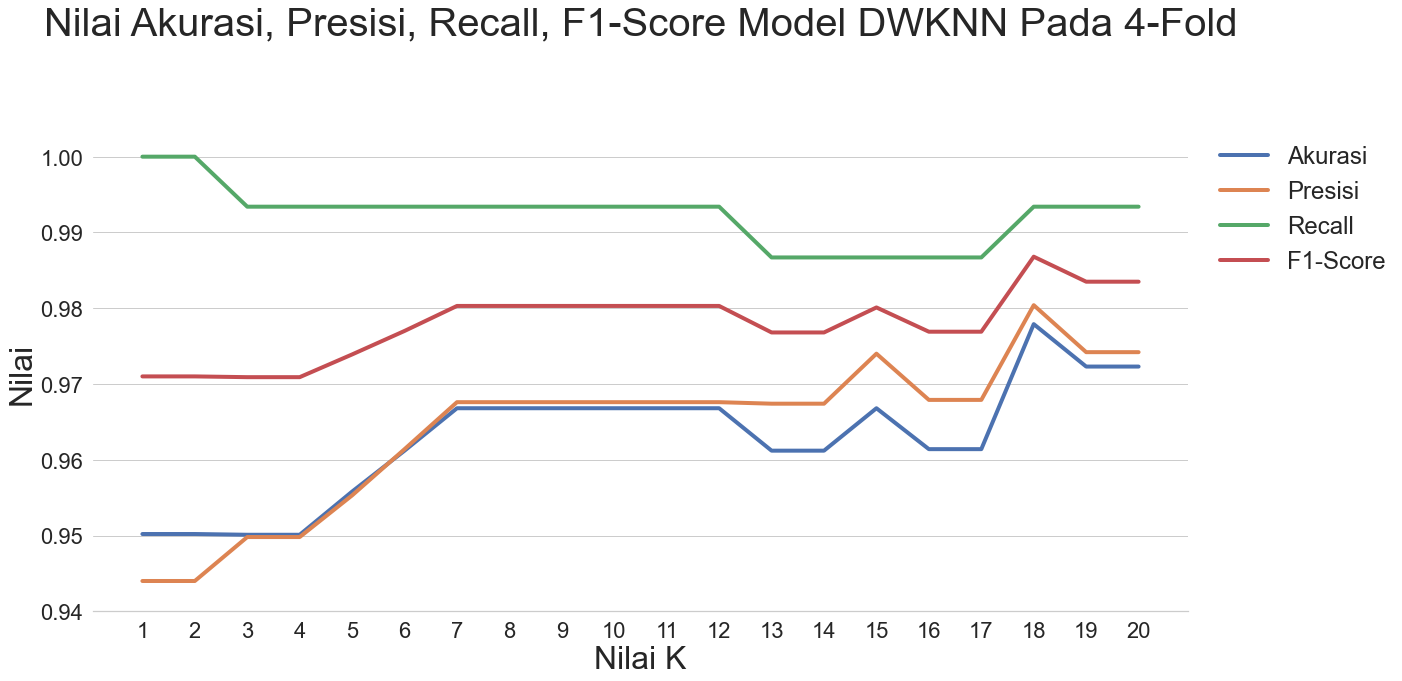

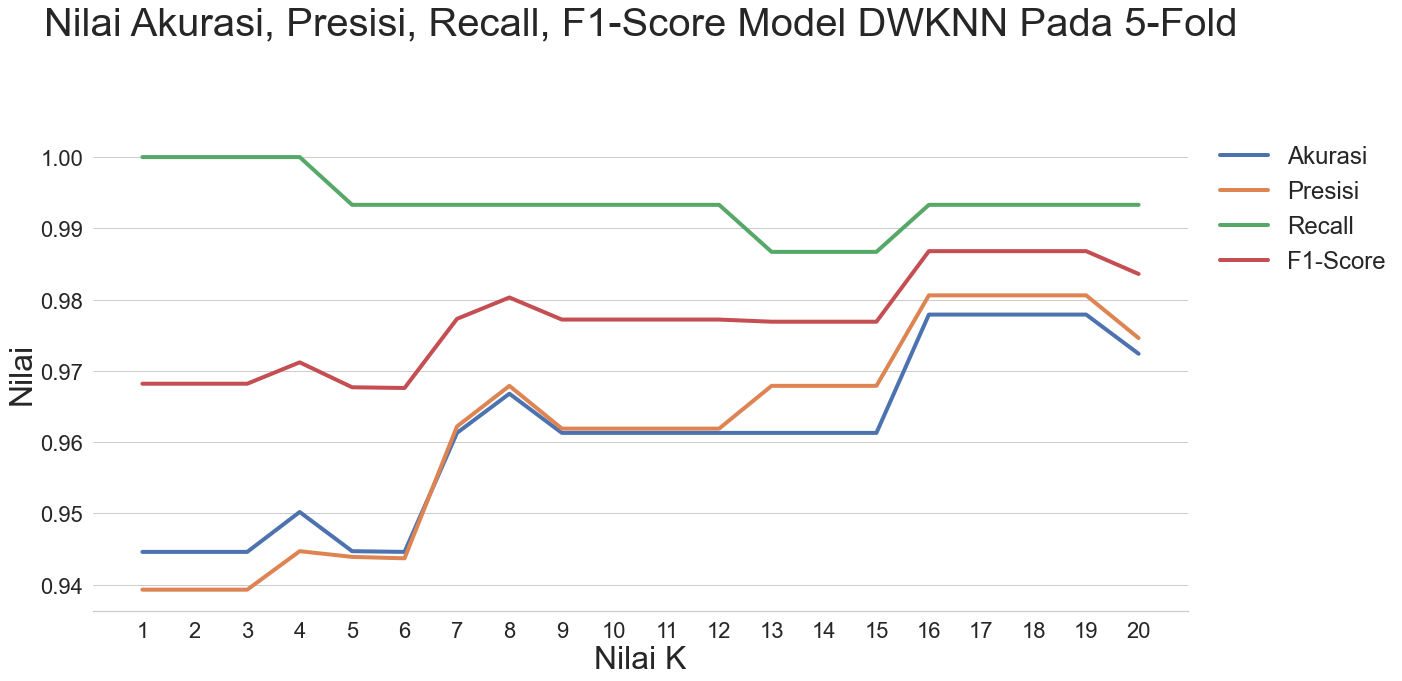

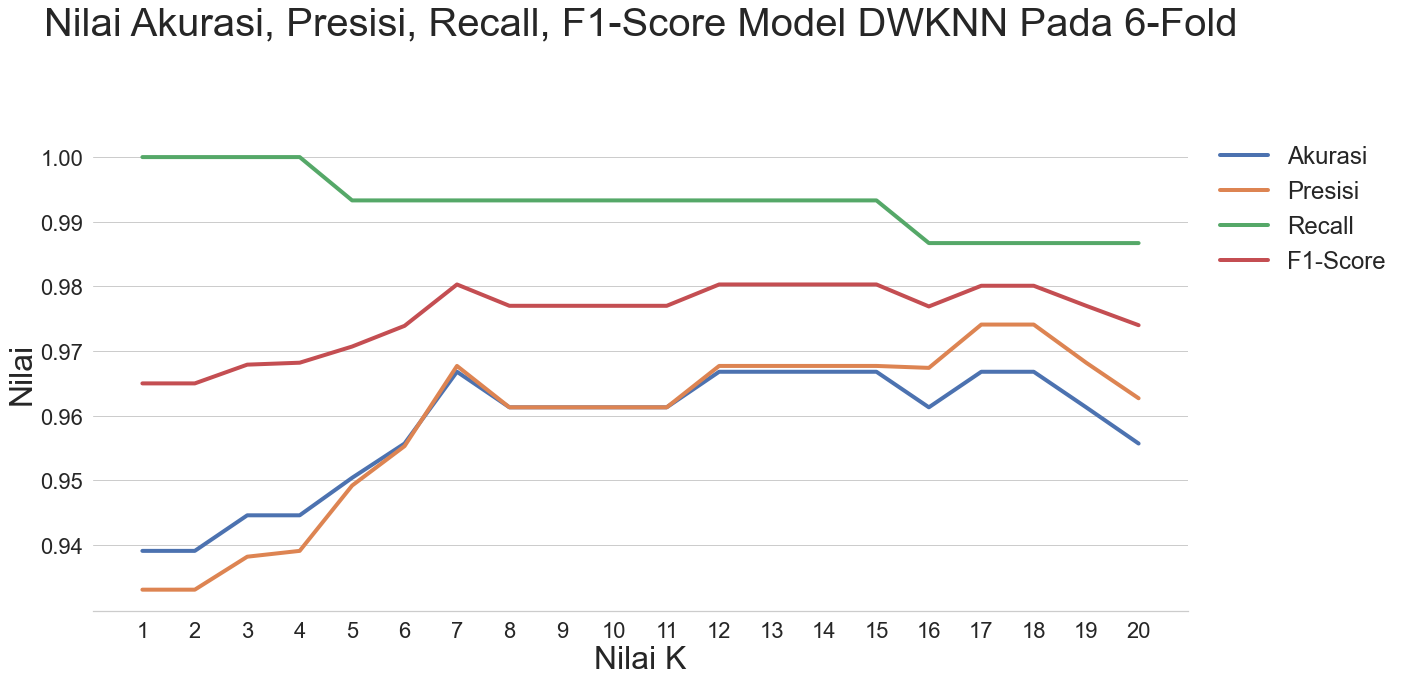

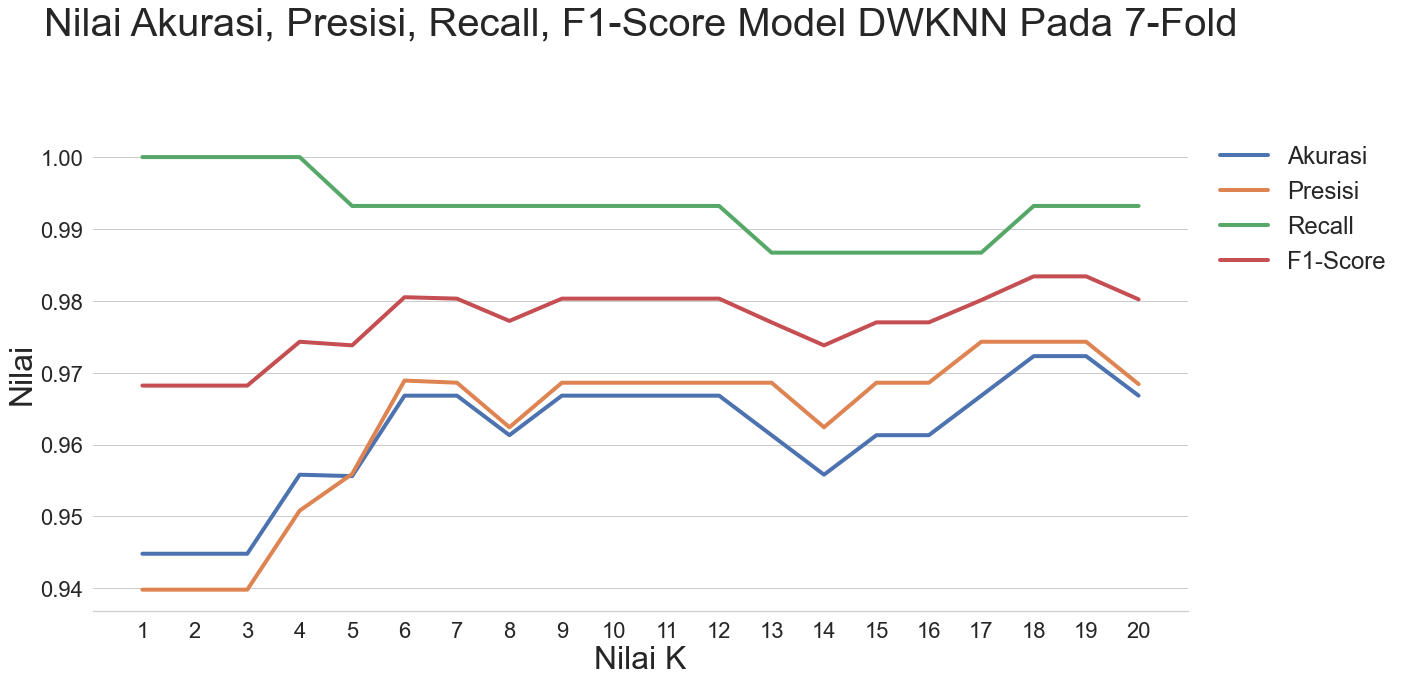

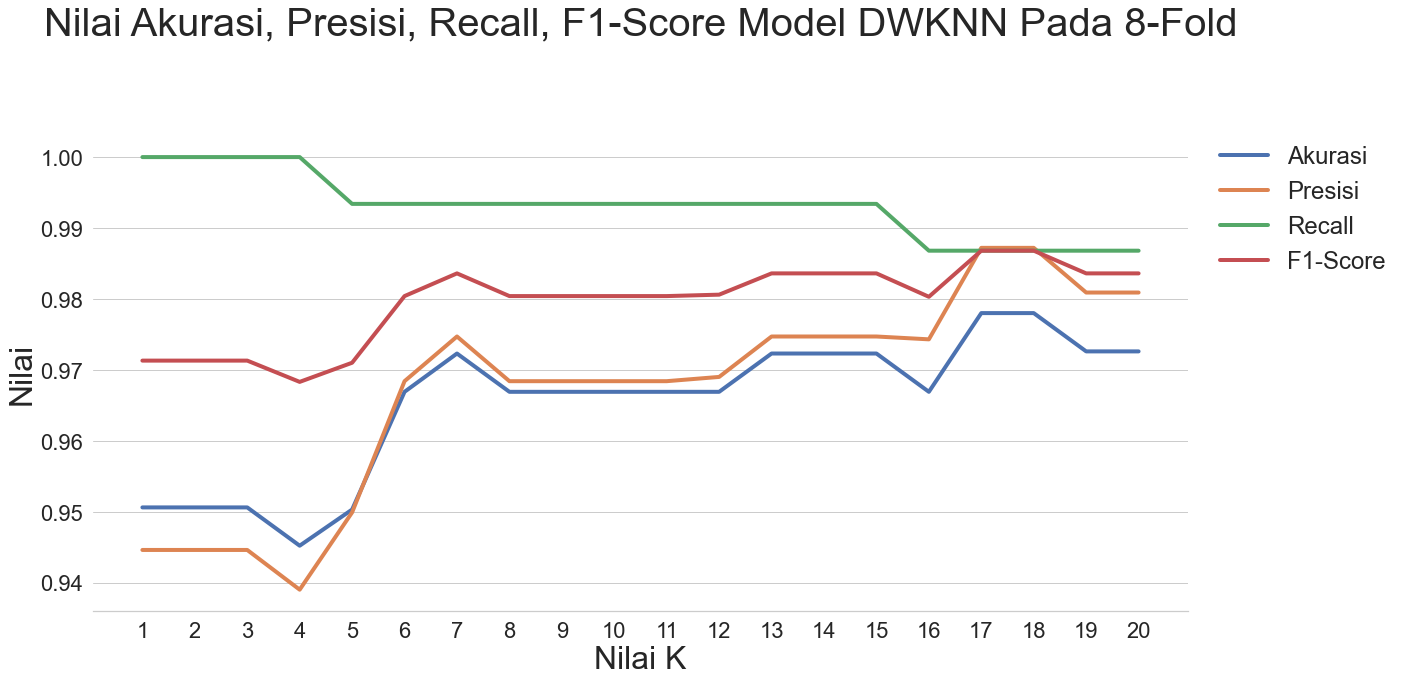

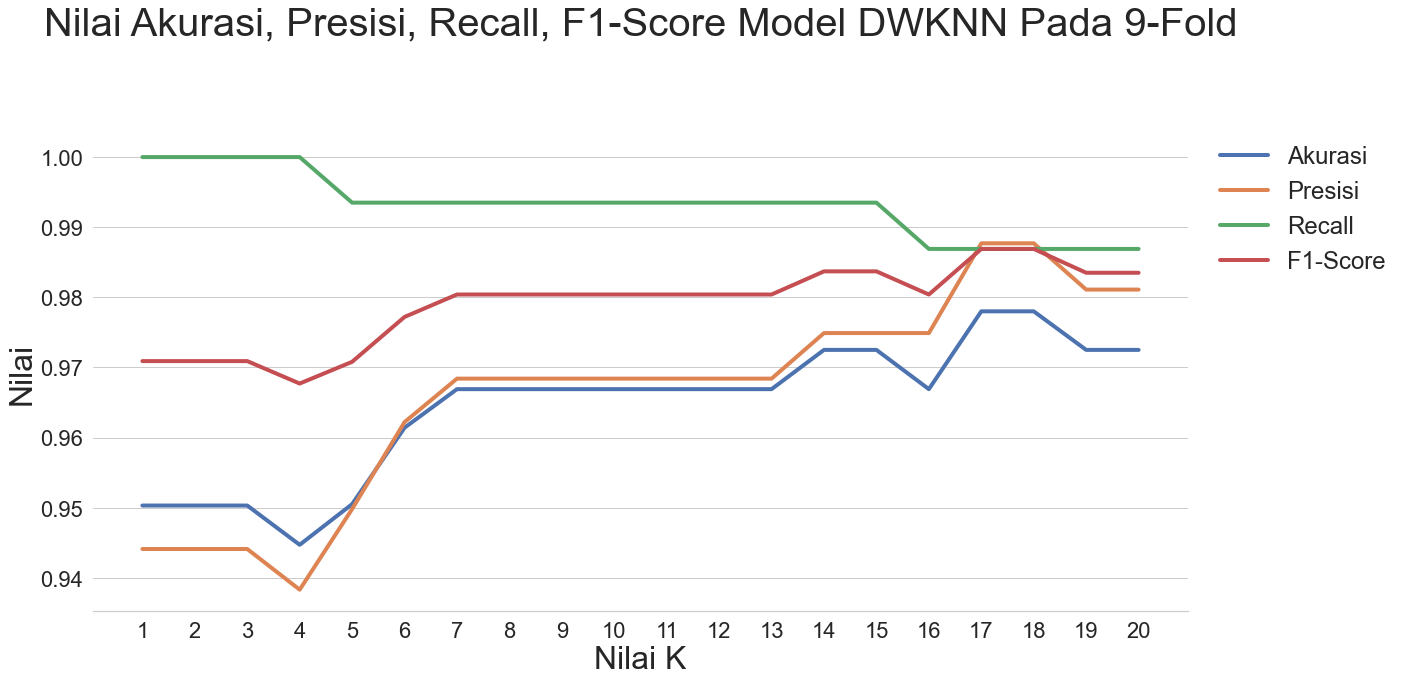

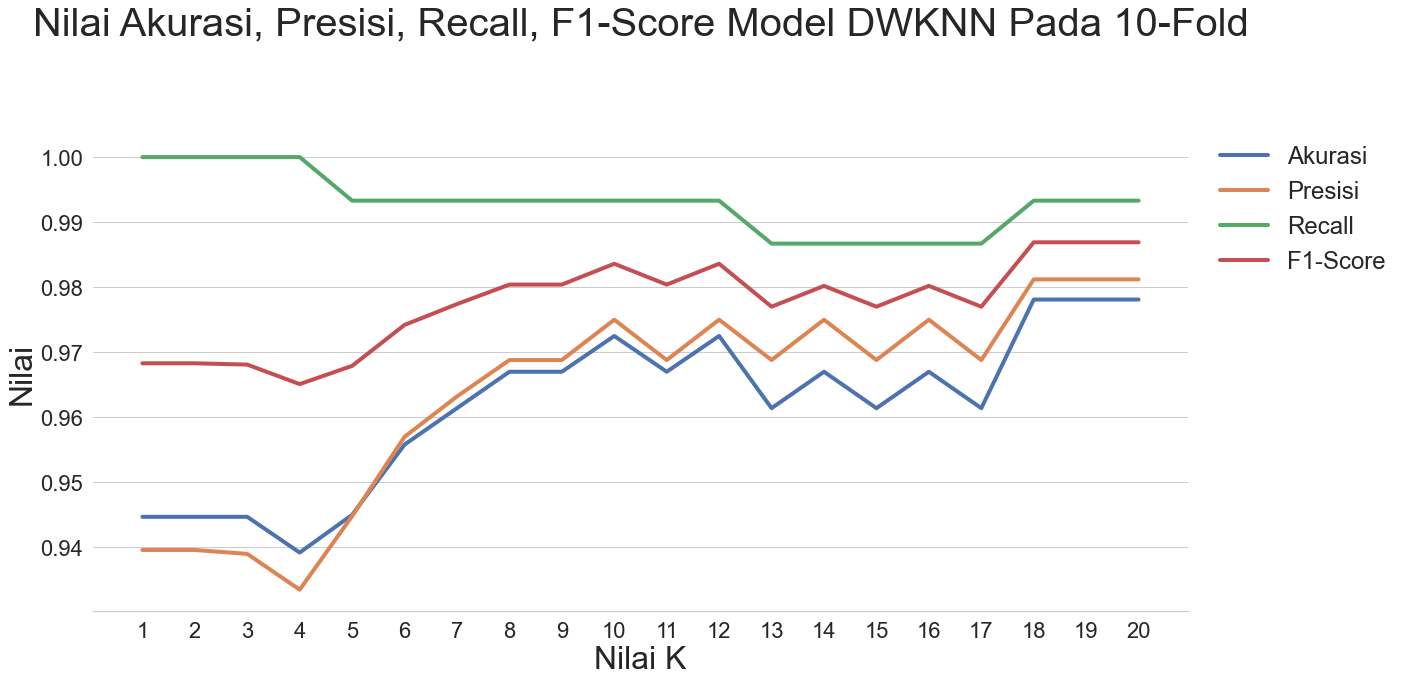

In [434]:
for i in range(9):
    plt.figure(figsize=(20,10))
    plt.rcParams['figure.autolayout'] = True
    sns.set(font_scale=2)
    sns.set_style('whitegrid')
    p = sns.lineplot(range_k0, kfld_d_acc[i], label='Akurasi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_prc[i], label='Presisi', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_rcl[i], label='Recall', linewidth=4)
    p = sns.lineplot(range_k0, kfld_d_f1[i], label='F1-Score', linewidth=4)
    p.set_title('Nilai Akurasi, Presisi, Recall, F1-Score Model DWKNN Pada {}-Fold'.format(i+2), fontsize=40, y=1.2)
    p.xaxis.grid(False)
    p.set_xlabel('Nilai K', fontsize=32)
    p.set_xticks(range(1,21))
    p.set_ylabel('Nilai', fontsize=32)
    p.set_yticks([0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1])
    sns.despine(left=True, bottom=False)
    p.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=24, frameon=False)
    p_fig = p.get_figure()
    p_fig.savefig('E:/Kuliah/SKRIPSI/PROG/OUTPUT/Plot/Lung/DW Per Fold/DW {}-Fold.png'.format(i+2))

In [439]:
pd.DataFrame(X)

0         1         2         3         4         5         6      \
0    0.375179  0.287532  0.269049  0.360570  0.636456  0.215852  0.066397   
1    0.356250  0.507888  0.233307  0.493025  0.580253  0.182073  0.142621   
2    0.526964  0.271756  0.195994  0.275793  0.487089  0.205825  0.087795   
3    0.384821  0.194402  0.309898  0.293730  0.562532  0.058880  0.098356   
4    0.400179  0.590840  0.396308  0.516940  0.993418  0.323299  0.093764   
..        ...       ...       ...       ...       ...       ...       ...   
176  0.413750  0.471756  0.324038  0.341714  0.702278  0.281513  0.116631   
177  0.287679  0.193893  0.168500  0.189330  0.724557  0.017707  0.126733   
178  0.490357  0.300763  0.230558  0.263222  0.865316  0.025999  0.099734   
179  0.423393  0.271756  0.200707  0.319025  0.698734  0.200576  0.093489   
180  0.526607  0.375573  0.257659  0.275487  0.661266  0.150253  0.120672   

        7         8         9      ...     12523     12524     12525  \
0    0.515220  0.008949  0.653018  ...  0.616359  0.310935  0.382253   
1    0.192192  0.102424  0.451735  ...  0.507781  0.346976  0.228669   
2    0.386159  0.016538  0.356520  ...  0.467608  0.339035  0.540273   
3    0.467513  0.005679  0.558406  ...  0.551936  0.373855  0.402730   
4    0.505665  0.203594  0.413364  ...  0.356858  0.348198  0.574061   
..        ...       ...       ...  ...       ...       ...       ...   
176  0.269247  0.000697  0.330647  ...  0.514658  0.412340  0.565529   
177  0.822413  0.019463  0.844598  ...  0.359030  0.432498  0.436519   
178  0.467513  0.018134  0.681138  ...  0.345277  0.309102  0.486348   
179  0.299823  0.006564  0.308557  ...  0.460369  0.314600  0.427304   
180  0.411616  0.012806  0.556871  ...  0.433949  0.315822  0.516382   

        12526     12527     12528     12529     12530     12531     12532  
0    0.749164  0.784075  0.349858  0.187671  0.151194  0.654613  0.517198  
1    0.723523  0.584197  0.357649  0.229809  0.140308  0.573747  0.560365  
2    0.476031  0.524883  0.276558  0.228248  0.485183  0.664009  0.421630  
3    0.773690  0.817388  0.290368  0.187281  0.103417  0.624431  0.463527  
4    0.740245  0.507820  0.135977  0.132657  0.190656  0.616173  0.314404  
..        ...       ...       ...       ...       ...       ...       ...  
176  0.628763  0.853138  0.398371  0.511120  0.127910  0.664579  0.444137  
177  0.363434  0.695105  0.147309  0.088958  0.122921  0.769362  0.435942  
178  0.691193  0.738168  0.513810  0.506048  0.122770  0.734624  0.435596  
179  0.614270  0.541133  0.337819  0.471323  0.096008  0.677392  0.902008  
180  0.566332  0.719277  0.268059  0.158798  0.104475  0.699886  0.552632  

[181 rows x 12533 columns]

In [437]:
X[:,0]

array([0.38, 0.36, 0.53, 0.38, 0.4 , 0.89, 0.35, 0.53, 0.26, 0.59, 0.41,
       0.  , 0.07, 0.81, 0.4 , 0.47, 0.13, 0.38, 0.77, 0.46, 0.35, 0.61,
       0.51, 0.54, 0.38, 0.43, 0.39, 0.45, 0.49, 0.14, 0.32, 0.63, 0.03,
       0.47, 0.34, 0.51, 0.57, 0.57, 0.4 , 0.42, 0.37, 0.36, 0.16, 0.26,
       0.54, 0.11, 0.27, 0.9 , 0.51, 0.36, 0.25, 0.52, 0.62, 0.65, 0.67,
       0.31, 0.32, 0.1 , 0.13, 0.26, 0.6 , 0.41, 0.4 , 0.25, 0.13, 0.7 ,
       0.62, 0.53, 0.43, 0.48, 0.41, 0.59, 0.45, 0.55, 0.36, 0.46, 0.5 ,
       0.79, 0.36, 0.45, 0.43, 0.4 , 0.49, 0.6 , 0.38, 0.52, 0.46, 0.16,
       0.53, 0.45, 0.53, 0.37, 0.56, 0.44, 0.22, 0.54, 0.31, 0.54, 0.45,
       0.52, 0.55, 0.58, 0.5 , 0.37, 0.68, 0.64, 0.51, 0.51, 0.4 , 0.65,
       0.36, 0.46, 0.51, 0.38, 0.4 , 0.55, 0.39, 0.35, 0.33, 0.36, 0.41,
       0.47, 0.36, 0.18, 0.37, 0.54, 0.33, 0.65, 0.47, 0.65, 0.71, 0.61,
       0.6 , 0.5 , 0.4 , 0.46, 0.54, 0.58, 0.31, 0.54, 0.67, 0.64, 0.53,
       1.  , 0.57, 0.48, 0.36, 0.5 , 0.97, 0.63, 0.

In [438]:
X[:,1]

array([0.29, 0.51, 0.27, 0.19, 0.59, 0.23, 0.29, 0.18, 0.32, 0.39, 0.32,
       0.36, 0.41, 0.89, 0.68, 0.25, 0.37, 0.4 , 0.17, 0.26, 0.58, 0.42,
       0.38, 0.22, 0.25, 0.41, 0.32, 0.33, 0.28, 0.27, 0.38, 0.22, 0.24,
       0.19, 0.17, 0.18, 0.18, 0.33, 0.21, 0.3 , 0.4 , 0.14, 0.47, 0.46,
       0.  , 0.5 , 0.63, 0.35, 0.35, 0.39, 0.33, 0.3 , 0.37, 0.35, 0.34,
       0.41, 0.34, 0.05, 0.27, 0.25, 0.36, 1.  , 0.39, 0.34, 0.32, 0.32,
       0.39, 0.35, 0.3 , 0.29, 0.34, 0.3 , 0.52, 0.2 , 0.29, 0.54, 0.28,
       0.24, 0.28, 0.3 , 0.32, 0.34, 0.45, 0.21, 0.44, 0.5 , 0.32, 0.34,
       0.27, 0.31, 0.21, 0.54, 0.49, 0.25, 0.39, 0.32, 0.27, 0.32, 0.28,
       0.39, 0.34, 0.27, 0.4 , 0.23, 0.34, 0.3 , 0.3 , 0.41, 0.38, 0.37,
       0.4 , 0.36, 0.22, 0.31, 0.21, 0.21, 0.24, 0.68, 0.15, 0.23, 0.26,
       0.23, 0.32, 0.27, 0.21, 0.27, 0.06, 0.28, 0.33, 0.21, 0.38, 0.32,
       0.42, 0.3 , 0.21, 0.24, 0.22, 0.2 , 0.39, 0.41, 0.35, 0.3 , 0.23,
       0.32, 0.41, 0.37, 0.27, 0.34, 0.3 , 0.47, 0.

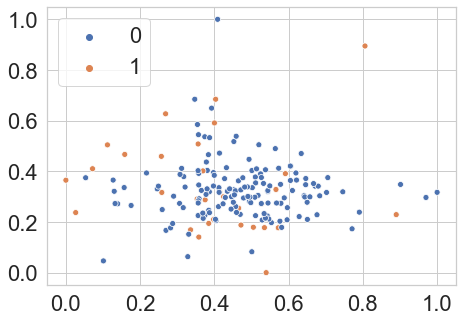

In [466]:
plt.figure(figsize=(7, 5))
p = sns.scatterplot(X[:,0], X[:,1], hue=y)
plt.show()

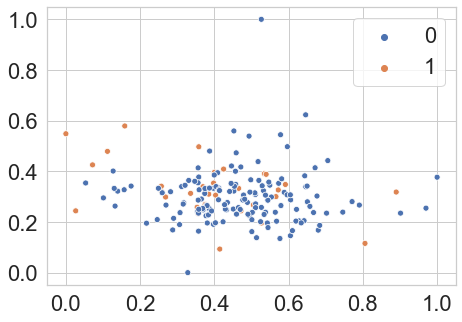

In [465]:
plt.figure(figsize=(7, 5))
p = sns.scatterplot(X[:,0], X[:,2], hue=y)
plt.show()

0 1


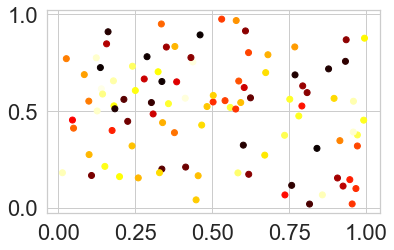

1 2


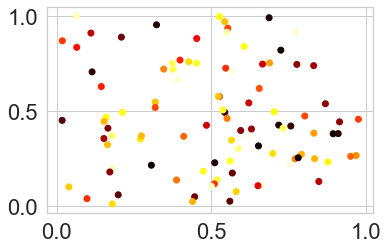

2 3


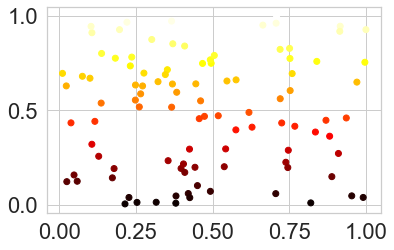

In [456]:
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# Random data of 100×3 dimension
data = np.array(np.random.random((100, 4)))

# Scatter plot
for i in range(3):
    print(i, i+1)
    plt.scatter(data[:, i], data[:, i+1], c=data[:, 3], cmap='hot')
    plt.show()

# Display the plot


In [451]:
data

array([[0.98, 0.97, 0.64, 0.75],
       [0.31, 0.09, 0.7 , 0.69],
       [0.61, 0.08, 0.69, 0.95],
       [0.51, 0.16, 0.83, 0.83],
       [0.02, 0.54, 0.42, 0.13],
       [0.76, 0.01, 0.26, 0.86],
       [0.37, 0.53, 0.23, 0.23],
       [0.35, 0.21, 0.45, 0.02],
       [0.33, 0.25, 0.49, 0.71],
       [0.44, 0.99, 0.39, 0.26],
       [0.19, 0.49, 0.09, 0.86],
       [0.17, 0.32, 0.9 , 0.01],
       [0.53, 0.33, 0.94, 0.53],
       [0.02, 0.96, 0.6 , 0.33],
       [0.47, 0.33, 0.35, 0.9 ],
       [0.1 , 0.28, 0.73, 0.93],
       [0.11, 0.37, 0.05, 0.2 ],
       [0.45, 0.57, 0.89, 0.06],
       [0.46, 0.19, 0.59, 0.58],
       [0.48, 0.84, 0.48, 0.52],
       [0.72, 0.62, 0.82, 0.18],
       [0.96, 0.8 , 0.89, 0.98],
       [0.33, 0.67, 0.05, 0.01],
       [0.75, 0.87, 0.09, 0.92],
       [0.87, 0.67, 0.1 , 0.37],
       [0.89, 0.05, 0.93, 0.24],
       [0.28, 0.81, 0.09, 1.  ],
       [0.03, 0.94, 0.36, 0.86],
       [0.89, 0.68, 0.94, 0.  ],
       [0.83, 0.18, 0.96, 0.49],
       [0.